In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from matplotlib import colors, ticker
import os 
import sys
import glob
from scipy.special import gamma

if '../bayes-drt' not in sys.path:
    sys.path.append('../bayes-drt')
import drt
import eis_utils as gt
from stan_models import load_pickle

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# load all stan models - required for unpickling DRT objects
sms = glob.glob('../bayes-drt/models/*.pkl')
for file in sms:
    load_pickle(file)

In [13]:
# tau_plot = np.logspace(-7,2,200)
# dr = drt.DRT()

In [393]:
data_path = '../data'
# glob.glob(os.path.join(data_path,'*.csv'))
en_path = '../comparisons/ElasticNet/results'
gp_path = '../comparisons/GP-DRT/results/for_figs'

model_info = {'PM':{'path':'bayes_results','color':'k'},
              'MAP':{'path':'map_results','color':'r'},
              'EN':{'path':en_path,'color':'purple'},
              'GP':{'path':gp_path,'color':'g'},
             }

tick_size = 9
label_size = 11

plt.rcParams['font.family'] = 'serif'
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['xtick.labelsize'] = tick_size
plt.rcParams['ytick.labelsize'] = tick_size
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['legend.fontsize'] = tick_size - 1

plotdir = 'images'
latexdir = 'C:\\Users\\jdh10\\OneDrive - Colorado School of Mines\\Research\\Manuscripts\\BayesianDRT_2020\\latex\\images'

In [4]:
# probability distributions
def pdf_gamma(x,shape,rate):
    return rate**shape*x**(shape-1)*np.exp(-x*rate)/(gamma(shape))

def pdf_invgamma(x,shape,rate):
    return rate**shape*x**(-shape-1)*np.exp(-rate/x)/(gamma(shape))

def pdf_exp(x,rate):
    return rate*np.exp(-rate*x)

def pdf_normal(x,mu,sigma):
    return (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((x-mu)/sigma)**2)

# Graphical Abstract

<IPython.core.display.Javascript object>


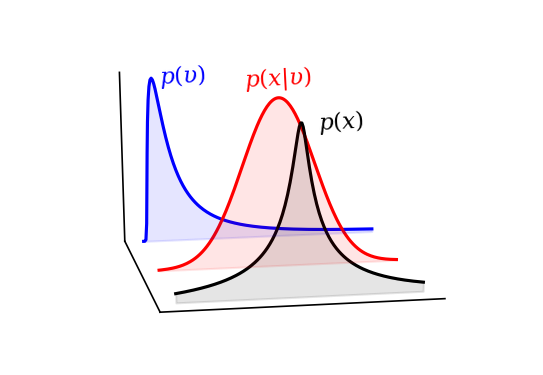

In [246]:
"Hierarchical prior visualization"

fig = plt.figure(figsize=(3.625,2.5))
ax = fig.add_subplot(111,projection='3d')

x1 = np.linspace(-1,1,200)
ups = np.arange(1e-5,1.5,0.01)
a = 0.05
b = 0.1
pxc = np.array([np.trapz(pdf_normal(x,0,ups)*pdf_invgamma(ups,a,b),x=ups) for x in x1])

x2 = np.linspace(1e-4,1,200)
pu = pdf_invgamma(x2,1,0.1)

px = pdf_normal(x1,0,0.3)

ys = [pxc,px,pu]
cs = ['k','r','b']
for n,(y,c) in enumerate(zip(ys,cs)):
    z = len(ys) - n
    
    # plot the line
    ax.plot(x1,(y/np.max(y))[::-1],z,zdir='y',label=col,zorder=-10*n,c=c)
    # fill
    ax.add_collection3d(plt.fill_between(x1,(y/np.max(y))[::-1],alpha=0.05,color=c),z,zdir='y')
    
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_zticks([])
ax.set_zticklabels([])

# these lines turn off the background grid. Comment them out if you want the grid in the background
for w_axis in [ax.w_xaxis,ax.w_yaxis,ax.w_zaxis]:
    w_axis._axinfo['grid'].update({'linestyle':':','color':(1,1,1,0)})
for axis in [ax.xaxis,ax.yaxis,ax.zaxis]:
    axis.set_pane_color((1,1,1,0))

# this sets the view angle. You can adjust it to rotate the plot to your liking
# azim sets the rotation, elev sets the elevation of the "camera"
ax.view_init(azim=80,elev=20)

ax.text(-0.7,0,0.5,'$p(x)$',zdir='x',size=11)
ax.text(-0.2,-1,0.65,r'$p(x|\upsilon)$',zdir='x',size=11,c='r')
ax.text(0.45,-2,0.55,r'$p(\upsilon)$',zdir='x',size=11,c='b')
    
fig.tight_layout()
fig.savefig(os.path.join(plotdir,'GraphAbs_priors.jpg'),dpi=500)

<IPython.core.display.Javascript object>


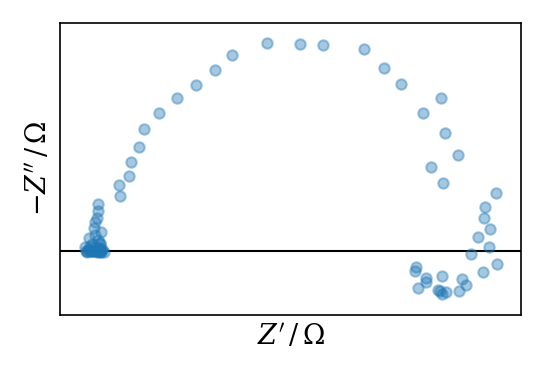

<IPython.core.display.Javascript object>


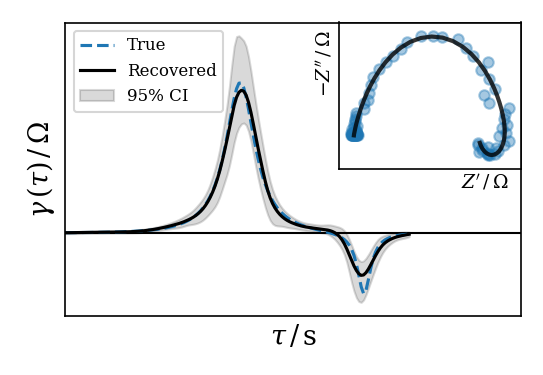

<IPython.core.display.Javascript object>


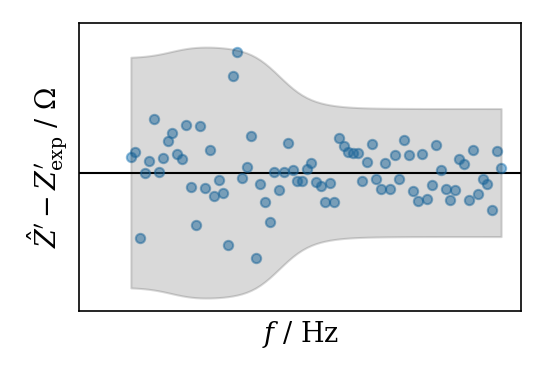

In [249]:
"Sample deconvolution for graphical abstract"
circ = 'ZARC-RL'
err_model = 'Macdonald'
noise_level = 1.0

# for Nyquist
fig1, ax1 = plt.subplots(figsize=(3.625,2.5))
# for DRT
fig2, ax2 = plt.subplots(figsize=(3.625,2.5))
# for error structure
fig3, ax3 = plt.subplots(figsize=(3.625,2.5))

Z_file = os.path.join(data_path,'simulated',f'Z_{circ}_noiseless.csv')
Zn_file = os.path.join(data_path,'simulated',f'Z_{circ}_{err_model}_{noise_level}.csv')
# get results filenames
fname = os.path.split(Zn_file)[1]
suffix = fname[1:-4]
Zout = f'Zout{suffix}.csv'
Gout = f'Gout{suffix}.csv'

# plot true DRT
if circ=='RC':
    ax.axvline(1e-2,lw=1,label='True',ls='--')
elif circ=='2RC':
    ax.axvline(1e-2,lw=1,label='True',ls='--')
    ax.axvline(1e-3,lw=1,ls='--')
else:
    g_file = os.path.join(data_path,'simulated',f'gamma_{circ}.csv')
    g_true = pd.read_csv(g_file)
    g_true = g_true[(g_true['tau']>= 1/(2*np.pi*Zdf['Freq'].max())) & (g_true['tau']<= 1/(2*np.pi*Zdf['Freq'].min()))]
    ax2.plot(g_true['tau'],g_true['gamma'],label='True',ls='--')

# plot impedance fit on ax1 and ax2 inset
axi = ax2.inset_axes([0.6,0.5,0.4,0.5])
Zdf = pd.read_csv(Z_file)
Zndf = pd.read_csv(Zn_file)
# gt.plot_nyquist(Zdf,ax=ax1,label='True',plot_func='plot',ls='--',label_size=tick_size)
gt.plot_nyquist(Zndf,ax=ax1,s=25,alpha=0.4,label_size=label_size+2)
gt.plot_nyquist(Zndf,ax=axi,s=25,alpha=0.4,label_size=label_size)

# plot estimated DRT
for model_name in ['PM']:
    path = model_info[model_name]['path']
    color = model_info[model_name]['color']
    # load results
    Zres = pd.read_csv(os.path.join(path,Zout))
    Gres = pd.read_csv(os.path.join(path,Gout))
    # limit DRT range to data range to avoid large CIs on GP
    Gres = Gres[(Gres['tau']>= 1/(2*np.pi*Zdf['Freq'].max())) & (Gres['tau']<= 1/(2*np.pi*Zdf['Freq'].min()))]

    # plot DRT on appropriate axis
    if model_name=='PM':
        ax2.plot(Gres['tau'],Gres['gamma'],label='Recovered',c=color)
        ax2.fill_between(Gres['tau'],Gres['gamma_lo'],Gres['gamma_hi'],alpha=0.15,label='95% CI',
                               color=color,lw=1)
    elif model_name=='MAP':
        ax2.plot(Gres['tau'],Gres['gamma'],label='MAP',c=color,ls='-',alpha=1)

    # plot impedance fit on inset
    if model_name=='PM':
        # parse complex numbers
        real_cols = ['freq','Zreal','Zimag']
        for col in real_cols:
            Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x))
            Zres[col] = np.real(Zres[col])
        imag_cols = ['Zlo','Zhi']
        for col in imag_cols:
            Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x))      
        gt.plot_nyquist(Zres,ax=axi,plot_func='plot',label=model_name,c=color,lw=2,alpha=0.8,label_size=tick_size)
    else:
        gt.plot_nyquist(Zres,ax=axi,plot_func='plot',label=model_name,c=color,lw=2,alpha=0.8,label_size=tick_size,
                        ls='-')
        
    # plot residuals
    ax3.scatter(Zdf['Freq'],(Zres['Zreal']-Zndf['Zreal']),s=20,alpha=0.5)


# PM error scale
dr_mcmc = load_pickle(os.path.join(model_info['PM']['path'],f'obj{suffix}.pkl'))
sigma_re,sigma_im = dr_mcmc.predict_err_scale(dr_mcmc.f_train)#Zdf['Freq'].values)
ax3.fill_between(Zdf['Freq'],-3*sigma_re,3*sigma_re,alpha=0.15,color='k',lw=1,label='3$\sigma^\prime$')
# axes[0,1].fill_between(freq,-3e3*sigma_im,3e3*sigma_im,alpha=0.15,color='k',lw=1,label='PM $\pm 3 \sigma$')
        
        
# formatting        
# ax1.axhline(0,lw=1,c='k')

ax2.set_xscale('log')
# ax2.axhline(0,c='k',lw=1)
ax2.legend(loc='upper left')
ax2.set_xlabel(r'$\tau \, / \, $s',size=label_size+2)
ax2.set_ylabel(r'$\gamma\,(\tau) \, / \, \Omega$',size=label_size+2)
ax2.set_xlim(5e-6,2e3)

axi.set_xticks([])
axi.set_yticks([])
axi.get_legend().remove()
axi.xaxis.set_label_coords(0.8,-0.025)
axi.yaxis.set_label_coords(-0.025,0.72)

ax3.set_xscale('log')
ax3.set_xlabel('$f$ / Hz',size=label_size+2)
ax3.set_ylabel('$\hat{Z}^{\prime} - Z^{\prime}_{\mathrm{exp}}$ / $\Omega$',size=label_size+2)

for ax in [ax1,ax2,ax3]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axhline(0,lw=1,c='k',zorder=-20)

for fig in [fig1,fig2,fig3]:
    fig.tight_layout()
    
fig1.savefig(os.path.join(plotdir,'GraphAbs_Nyquist.jpg'),dpi=500)
fig2.savefig(os.path.join(plotdir,'GraphAbs_DRT.jpg'),dpi=500)
fig3.savefig(os.path.join(plotdir,'GraphAbs_Error.jpg'),dpi=500)

In [220]:
fig,axes = plt.subplots(1,2,figsize=(7.25,3))

gt.plot_bode(Zdf,axes=axes,cols=['Zreal','Zimag'])
gt.plot_bode(Zres,axes=axes,cols=['Zreal','Zimag'])

0    -0.002020
1    -0.002043
2    -0.002078
3    -0.002130
4    -0.002196
        ...   
76    0.000683
77    0.000721
78    0.000767
79    0.000813
80    0.000854
Name: Zreal, Length: 81, dtype: float64

# Prior distributions

<IPython.core.display.Javascript object>


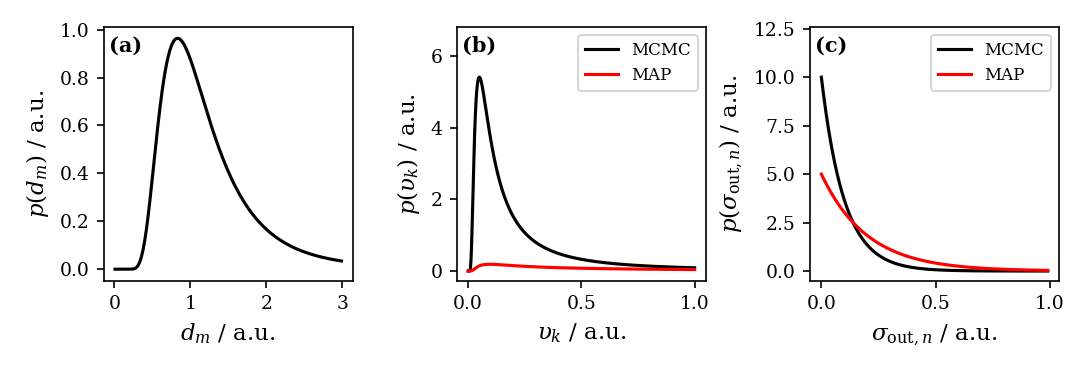

C:\Users\jdh10\anaconda3\envs\stan\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """
C:\Users\jdh10\anaconda3\envs\stan\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
C:\Users\jdh10\anaconda3\envs\stan\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
C:\Users\jdh10\anaconda3\envs\stan\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """
C:\Users\jdh10\anaconda3\envs\stan\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
C:\Users\jdh10\anaconda3\envs\stan\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
C:\Users\jdh10\anaconda3\envs\stan\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """
C:\Users\jdh10\anaconda3\envs\st

In [189]:
fig, axes = plt.subplots(1,3,figsize=(7.25,2.5))

# d0-2 prior
x = np.arange(0,3,0.01)
axes[0].plot(x,pdf_invgamma(x,5,5),c='k')
axes[0].set_xlabel('$d_m$ / a.u.')
axes[0].set_ylabel('$p(d_m)$ / a.u.')

# upsilon prior
x = np.arange(0,1,0.001)
axes[1].plot(x,pdf_invgamma(x,1,0.1),c='k',label='MCMC')
axes[1].plot(x,pdf_invgamma(x,0.05,0.1),c='r',label='MAP')
axes[1].set_xlabel(r'$\upsilon_k$ / a.u.')
axes[1].set_ylabel(r'$p(\upsilon_k)$ / a.u.')

# sigma_out prior
x = np.arange(0,1,0.01)
axes[2].plot(x,pdf_exp(x,10),c='k',label='MCMC')
axes[2].plot(x,pdf_exp(x,5),c='r',label='MAP')
axes[2].set_xlabel('$\sigma_{\mathrm{out},n}$ / a.u.')
axes[2].set_ylabel('$p(\sigma_{\mathrm{out},n})$ / a.u.')

for ax in axes[1:]:
    ax.legend()
    # make room for subfig labels
    ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1]*1.2)
    
# subfigure labels
for n,ax in enumerate(axes.ravel()):
    let = chr(n+97)
    ax.text(0.02,0.9,f'({let})',transform=ax.transAxes,fontweight='bold')
    
fig.tight_layout()
fig.savefig(os.path.join(plotdir,'Priors.jpg'),dpi=500)
fig.savefig(os.path.join(latexdir,'Priors.pdf'),dpi=500)

# Illustrative example: ZARC

C:\Users\jdh10\anaconda3\envs\stan\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


<IPython.core.display.Javascript object>


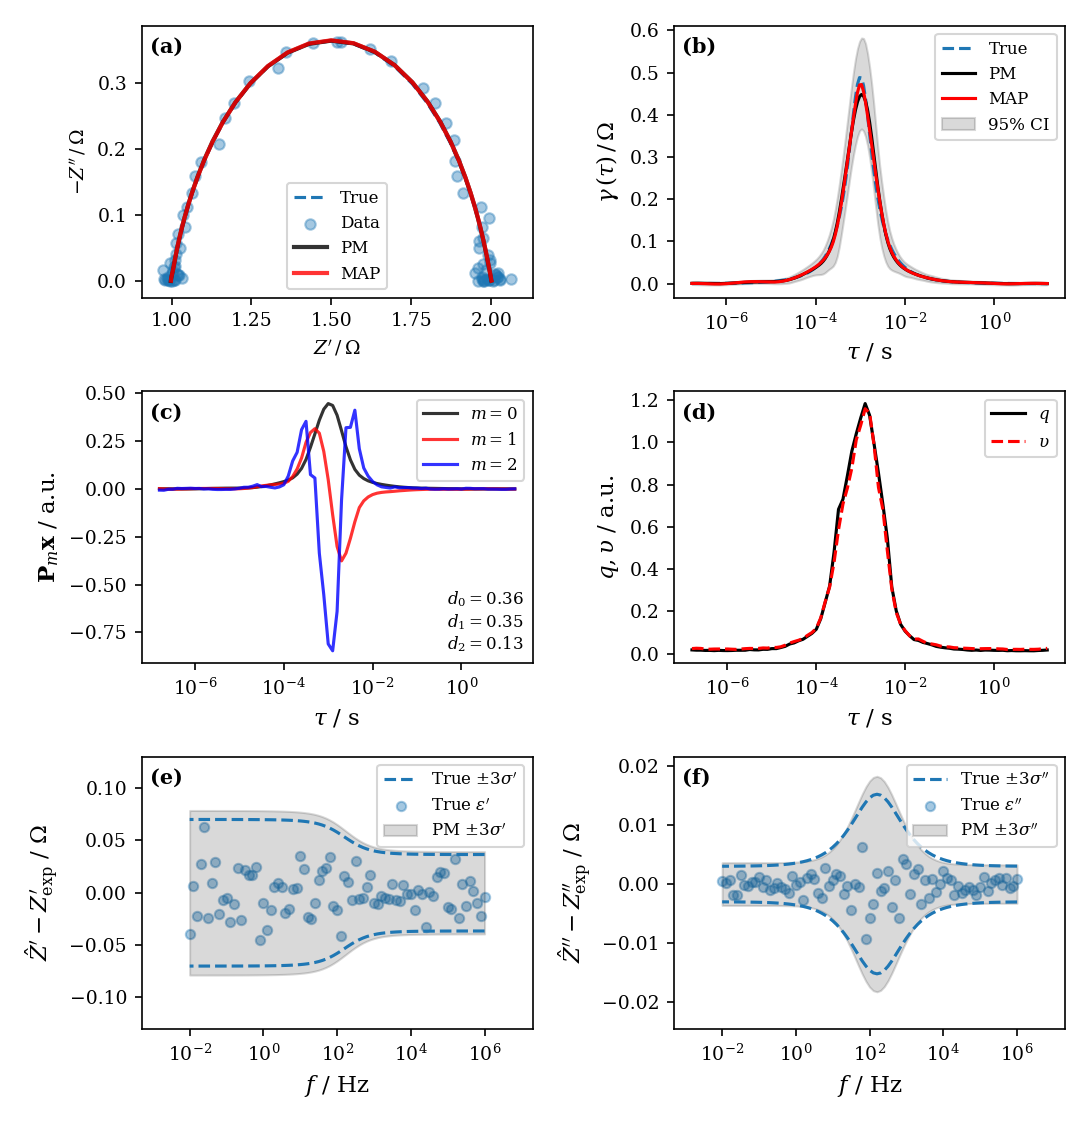

In [385]:
circ = 'ZARC'
err_model = 'Macdonald'
noise_level = 1.0

fig,axes = plt.subplots(3,2,figsize=(7.25,7.5))

# load impedance data
Z_file = os.path.join(data_path,'simulated',f'Z_{circ}_noiseless.csv')
Zn_file = os.path.join(data_path,'simulated',f'Z_{circ}_{err_model}_{noise_level}.csv')
# plot impedance data Nyquist
Zdf = pd.read_csv(Z_file)
Zndf = pd.read_csv(Zn_file)
gt.plot_nyquist(Zdf,ax=axes[0,0],label='True',plot_func='plot',ls='--',label_size=tick_size)
gt.plot_nyquist(Zndf,ax=axes[0,0],label='Data',s=25,alpha=0.4,label_size=tick_size)

# get results filenames
fname = os.path.split(Zn_file)[1]
suffix = fname[1:]
Zout = f'Zout{suffix}'
Gout = f'Gout{suffix}'
obj_out = f'obj{suffix}'.replace('.csv','.pkl')

# load true DRT
g_file = os.path.join(data_path,'simulated',f'gamma_{circ}.csv')
g_true = pd.read_csv(g_file)
g_true = g_true[(g_true['tau']>= 1/(2*np.pi*Zdf['Freq'].max())) & (g_true['tau']<= 1/(2*np.pi*Zdf['Freq'].min()))]
axes[0,1].plot(g_true['tau'],g_true['gamma'],label='True',ls='--')

for model_name in ['PM','MAP']:
    path = model_info[model_name]['path']
    color = model_info[model_name]['color']
    # load results
    Zres = pd.read_csv(os.path.join(path,Zout))
    Gres = pd.read_csv(os.path.join(path,Gout))
    # limit DRT range to data range
    Gres = Gres[(Gres['tau']>= 1/(2*np.pi*Zdf['Freq'].max())) & (Gres['tau']<= 1/(2*np.pi*Zdf['Freq'].min()))]

    # plot DRT on appropriate axis
    if model_name=='PM':
        axes[0,1].plot(Gres['tau'],Gres['gamma'],label='PM',c=color)
        axes[0,1].fill_between(Gres['tau'],Gres['gamma_lo'],Gres['gamma_hi'],alpha=0.15,label='95% CI',
                               color=color,lw=1)
    elif model_name=='MAP':
        axes[0,1].plot(Gres['tau'],Gres['gamma'],label='MAP',c=color,ls='-',alpha=1)

    # plot impedance fit
    if model_name=='PM':
        # parse complex numbers
        real_cols = ['freq','Zreal','Zimag']
        for col in real_cols:
            Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x))
            Zres[col] = np.real(Zres[col])
        comp_cols = ['Zlo','Zhi']
        for col in comp_cols:
            Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x))      
        gt.plot_nyquist(Zres,ax=axes[0,0],plot_func='plot',label=model_name,c=color,lw=2,alpha=0.8,label_size=tick_size)
    else:
        gt.plot_nyquist(Zres,ax=axes[0,0],plot_func='plot',label=model_name,c=color,lw=2,alpha=0.8,label_size=tick_size,
                        ls='-')

# load DRT objects to get hyperparameters
dr_mcmc = load_pickle(os.path.join(model_info['PM']['path'],obj_out))
# dr_map = load_pickle(os.path.join(model_info['MAP']['path'],obj_out))
# if noise_level > 0:
#     dr_mcmc._sigma_min = 0.002
#     dr_map._sigma_min = 0.002
# else:
#     dr_mcmc._sigma_min = 0.005
#     dr_map._sigma_min = 0.005


# plot derivatives
L0B = dr_mcmc.L0@dr_mcmc.coef_
L1B = dr_mcmc.L1@dr_mcmc.coef_
L2B = dr_mcmc.L2@dr_mcmc.coef_
d0 = np.mean(dr_mcmc._sample_result['d0_strength'])
d1 = np.mean(dr_mcmc._sample_result['d1_strength'])
d2 = np.mean(dr_mcmc._sample_result['d2_strength'])
axes[1,0].plot(dr_mcmc.tau,L0B,label='$m=0$',c='k',alpha=0.8)
axes[1,0].plot(dr_mcmc.tau,L1B,label='$m=1$',c='r',alpha=0.8)
axes[1,0].plot(dr_mcmc.tau,L2B,label='$m=2$',c='b',alpha=0.8)
# indicate values of d0-2 on plot
axes[1,0].text(0.78,0.05,'$d_0={:.2f}$\n$d_1={:.2f}$\n$d_2={:.2f}$'.format(d0,d1,d2),
              transform=axes[1,0].transAxes,size=tick_size-1)

# plot tau (upsilon in paper) and sum of squared derivs.
ups = np.mean(dr_mcmc._sample_result['tau'],axis=0)
LB = np.mean(dr_mcmc._sample_result['LB'],axis=0)
axes[1,1].plot(dr_mcmc.tau,LB,label='$q$',c='k')
axes[1,1].plot(dr_mcmc.tau,ups,label=r'$\upsilon$',c='r',ls='--')


# plot error structure
# plot true errors
axes[2,0].scatter(Zndf['Freq'],Zndf['Zreal']-Zdf['Zreal'],s=20,alpha=0.4,label=r'True $\varepsilon^{\prime}$')
axes[2,1].scatter(Zndf['Freq'],Zndf['Zimag']-Zdf['Zimag'],s=20,alpha=0.4,label=r'True $\varepsilon^{\prime\prime}$')
# plot true error scale
p = axes[2,0].plot(Zndf['Freq'],-3*Zndf['sigma_re'],label='True $\pm 3\sigma^{\prime}$',ls='--')
axes[2,0].plot(Zndf['Freq'],3*Zndf['sigma_re'],c=p[0].get_color(),ls='--')

p = axes[2,1].plot(Zndf['Freq'],-3*Zndf['sigma_im'],label='True $\pm 3\sigma^{\prime\prime}$',ls='--')
axes[2,1].plot(Zndf['Freq'],3*Zndf['sigma_im'],c=p[0].get_color(),ls='--')


# plot recovered error scale
sigma_re,sigma_im = dr_mcmc.predict_err_scale(dr_mcmc.f_train)
axes[2,0].fill_between(dr_mcmc.f_train,-3*sigma_re,3*sigma_re,alpha=0.15,color='k',lw=1,label='PM $\pm 3\sigma^{\prime}$')
axes[2,1].fill_between(dr_mcmc.f_train,-3*sigma_im,3*sigma_im,alpha=0.15,color='k',lw=1,label='PM $\pm 3\sigma^{\prime\prime}$')

# formatting
# sort legend for Nyquist plot
h,l = axes[0,0].get_legend_handles_labels()
srt_idx = [0,-1,1,2]
axes[0,0].legend(handles=[h[idx] for idx in srt_idx],labels=[l[idx] for idx in srt_idx])
    
for ax in axes.ravel()[1:]:
    ax.set_xscale('log')
    ax.legend()

for ax in axes.ravel()[1:4]:
    ax.set_xlabel(r'$\tau$ / s')
    
axes[0,1].set_ylabel(r'$\gamma\,(\tau) \, / \, \Omega$')
axes[1,0].set_ylabel('$\mathbf{P}_m \mathbf{x}$ / a.u.')
axes[1,1].set_ylabel(r'$q,\upsilon$ / a.u.')
    
axes[2,0].set_ylabel('$\hat{Z}^{\prime} - Z^{\prime}_{\mathrm{exp}}$ / $\Omega$')
axes[2,1].set_ylabel('$\hat{Z}^{\prime\prime} - Z^{\prime\prime}_{\mathrm{exp}}$ / $\Omega$')

for ax in axes[2]:
    ax.set_xlabel('$f$ / Hz')
    # make more room for legends
    ax.set_xlim(Zndf['Freq'].min()/20,Zndf['Freq'].max()*20)
    ax.legend(loc='upper right')
    
# make more room for legend
axes[2,0].set_ylim(-0.13,0.13)

# subfigure labels
for n,ax in enumerate(axes.ravel()):
    let = chr(n+97)
    ax.text(0.02,0.9,f'({let})',transform=ax.transAxes,fontweight='bold')

fig.tight_layout()
fig.savefig(os.path.join(plotdir,'ZARC_IllusEx.jpg'),dpi=500)
fig.savefig(os.path.join(latexdir,'ZARC_IllusEx.pdf'),dpi=500)

# Results for all simulated spectra at low noise
## Bayesian posterior distribution & MAP

In [278]:
# axis transform
def ydata_to_axis(ax,y):
    trans = ax.transAxes.inverted() + ax.transData
#     tans = trans.inverted()
    ytrans = trans.transform((1,y))[1]
    return ytrans

In [283]:
ax.transLimits.transform((1,0))[1]

0.2654632875753474

C:\Users\jdh10\anaconda3\envs\stan\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


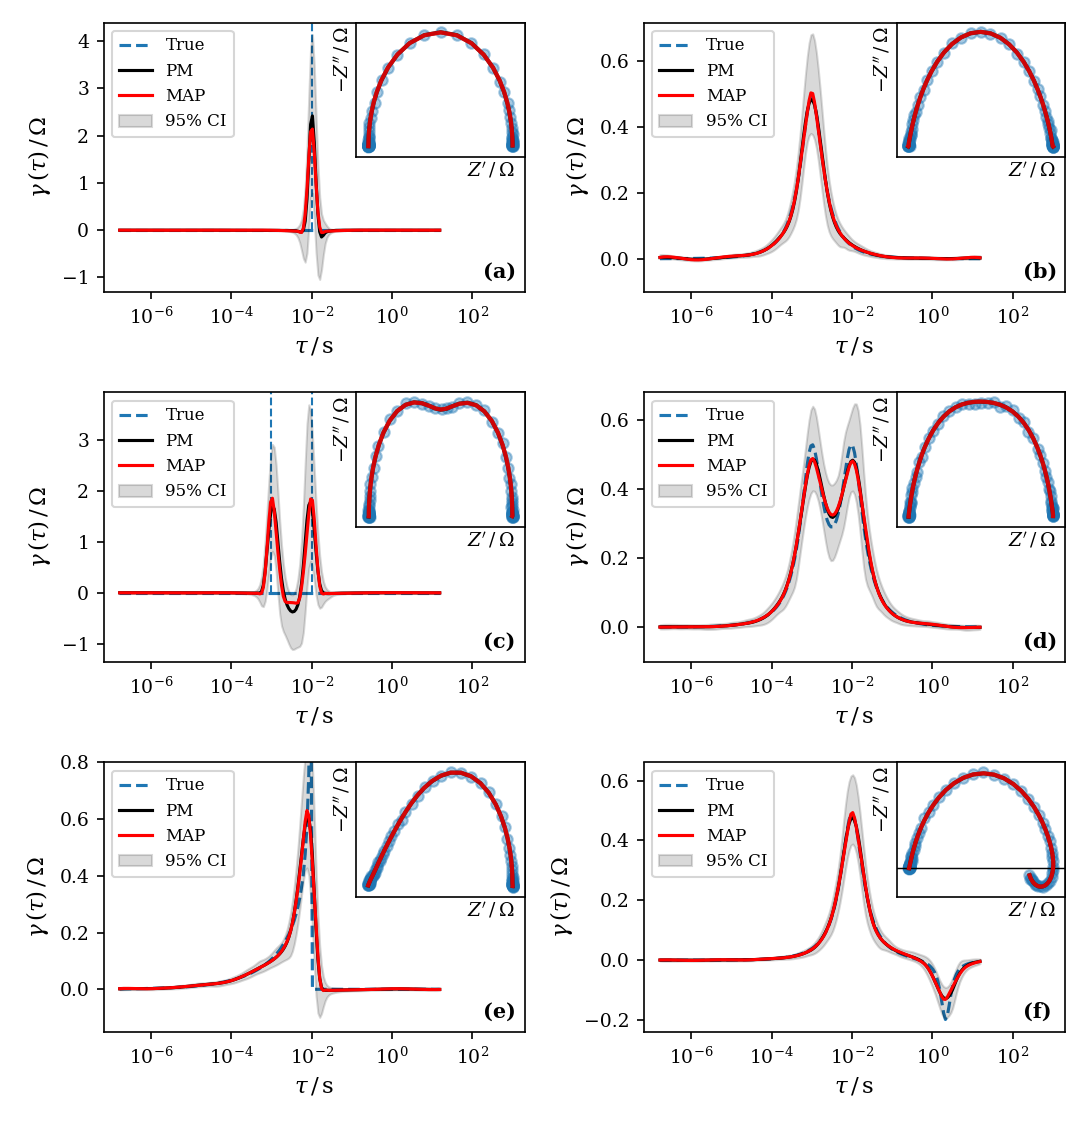

In [386]:
"Plot DRTs for all simulated spectra"

fig,axes_bm = plt.subplots(3,2,figsize=(7.25,7.5))#,sharex=True)

circuits = ['RC','ZARC','2RC','2ZARC','Gerischer','ZARC-RL']
err_model = 'uniform'
noise_level = 0.25

for circ,ax in zip(circuits,axes_bm.ravel()):
    Z_file = os.path.join(data_path,'simulated',f'Z_{circ}_noiseless.csv')
    Zn_file = os.path.join(data_path,'simulated',f'Z_{circ}_{err_model}_{noise_level}.csv')
    # get results filenames
    fname = os.path.split(Zn_file)[1]
    suffix = fname[1:]
    Zout = f'Zout{suffix}'
    Gout = f'Gout{suffix}'
        
    # plot impedance data on inset
    axi = ax.inset_axes([0.6,0.5,0.4,0.5])
    Zdf = pd.read_csv(Z_file)
    Zndf = pd.read_csv(Zn_file)
    gt.plot_nyquist(Zdf,ax=axi,label='True',plot_func='plot',ls='--',label_size=tick_size)
    gt.plot_nyquist(Zndf,ax=axi,label='Data',s=25,alpha=0.4,label_size=tick_size)
    if circ=='ZARC-RL':
        axi.axhline(0,lw=0.7,c='k')
            
    # plot estimated DRT
    for model_name in ['PM','MAP']:
        path = model_info[model_name]['path']
        color = model_info[model_name]['color']
        # load results
        Zres = pd.read_csv(os.path.join(path,Zout))
        Gres = pd.read_csv(os.path.join(path,Gout))
        # limit DRT range to data range
        tmin = 1/(2*np.pi*Zdf['Freq'].max())
        tmax = 1/(2*np.pi*Zdf['Freq'].min())
        Gres = Gres[(Gres['tau']>= tmin) & (Gres['tau']<= tmax)]
        
        # plot DRT on appropriate axis
        if model_name=='PM':
            ax.plot(Gres['tau'],Gres['gamma'],label='PM',c=color)
            ax.fill_between(Gres['tau'],Gres['gamma_lo'],Gres['gamma_hi'],alpha=0.15,label='95% CI',
                                   color=color,lw=1)
        elif model_name=='MAP':
            ax.plot(Gres['tau'],Gres['gamma'],label='MAP',c=color,ls='-',alpha=1)
            
        # plot impedance fit
        if model_name=='PM':
            # parse complex numbers
            real_cols = ['freq','Zreal','Zimag']
            for col in real_cols:
                Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x))
                Zres[col] = np.real(Zres[col])
            imag_cols = ['Zlo','Zhi']
            for col in imag_cols:
                Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x))      
            gt.plot_nyquist(Zres,ax=axi,plot_func='plot',label=model_name,c=color,lw=2,alpha=0.8,label_size=tick_size)
        else:
            gt.plot_nyquist(Zres,ax=axi,plot_func='plot',label=model_name,c=color,lw=2,alpha=0.8,label_size=tick_size,
                            ls='-')
            
    ax.set_xscale('log')
    ax.set_xlabel(r'$\tau \, / \, $s')
    ax.set_ylabel(r'$\gamma\,(\tau) \, / \, \Omega$')
    ax.set_xlim(ax.get_xlim()[0],2e3)
    
    axi.set_xticks([])
    axi.set_yticks([])
    axi.get_legend().remove()
    axi.xaxis.set_label_coords(0.8,-0.025)
    axi.yaxis.set_label_coords(-0.025,0.72)
    
    if circ=='Gerischer':
        ax.set_ylim(ax.get_ylim()[0],0.8)
        
    # need to have same ylim as EN/GP plots - make room for GP CI
    if ax.get_ylim()[0] > -0.1:
        ax.set_ylim(-0.1,ax.get_ylim()[1])
        
    # plot true DRT (vlines and hlines must come after all axis adjustments)
    if circ=='RC':
        ax.axvline(1e-2,lw=1,ls='--',ymin=ax.transLimits.transform((1,0))[1],zorder=-10)
        ax.axhline(0,ls='--',zorder=-10,label='True',xmin=ax.transLimits.transform((np.log10(tmin),0))[0],
                  xmax=ax.transLimits.transform((np.log10(tmax),0))[0])
    elif circ=='2RC':
        ax.axvline(1e-2,lw=1,ls='--',ymin=ax.transLimits.transform((1,0))[1],zorder=-10)
        ax.axvline(1e-3,lw=1,ls='--',ymin=ax.transLimits.transform((1,0))[1],zorder=-10)
        ax.axhline(0,ls='--',zorder=-10,label='True',xmin=ax.transLimits.transform((np.log10(tmin),0))[0],
                  xmax=ax.transLimits.transform((np.log10(tmax),0))[0])
    else:
        g_file = os.path.join(data_path,'simulated',f'gamma_{circ}.csv')
        g_true = pd.read_csv(g_file)
        g_true = g_true[(g_true['tau']>= 1/(2*np.pi*Zdf['Freq'].max())) & (g_true['tau']<= 1/(2*np.pi*Zdf['Freq'].min()))]
        ax.plot(g_true['tau'],g_true['gamma'],label='True',ls='--',zorder=-10)
        
    # reorder legends
    h,l = ax.get_legend_handles_labels()
    srt_idx = [2,0,1,3]
    ax.legend(handles=[h[i] for i in srt_idx],labels=[l[i] for i in srt_idx],loc='upper left')
        
# subfigure labels
for n,ax in enumerate(axes_bm.ravel()):
    let = chr(n+97)
    ax.text(0.9,0.05,f'({let})',transform=ax.transAxes,fontweight='bold')
    
fig.tight_layout()
fig.savefig(os.path.join(plotdir,'DRTs_AllSimData.jpg'),dpi=500)
fig.savefig(os.path.join(latexdir,'DRTs_AllSimData.pdf'),dpi=500)

## Elastic Net & Gaussian Process

C:\Users\jdh10\anaconda3\envs\stan\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


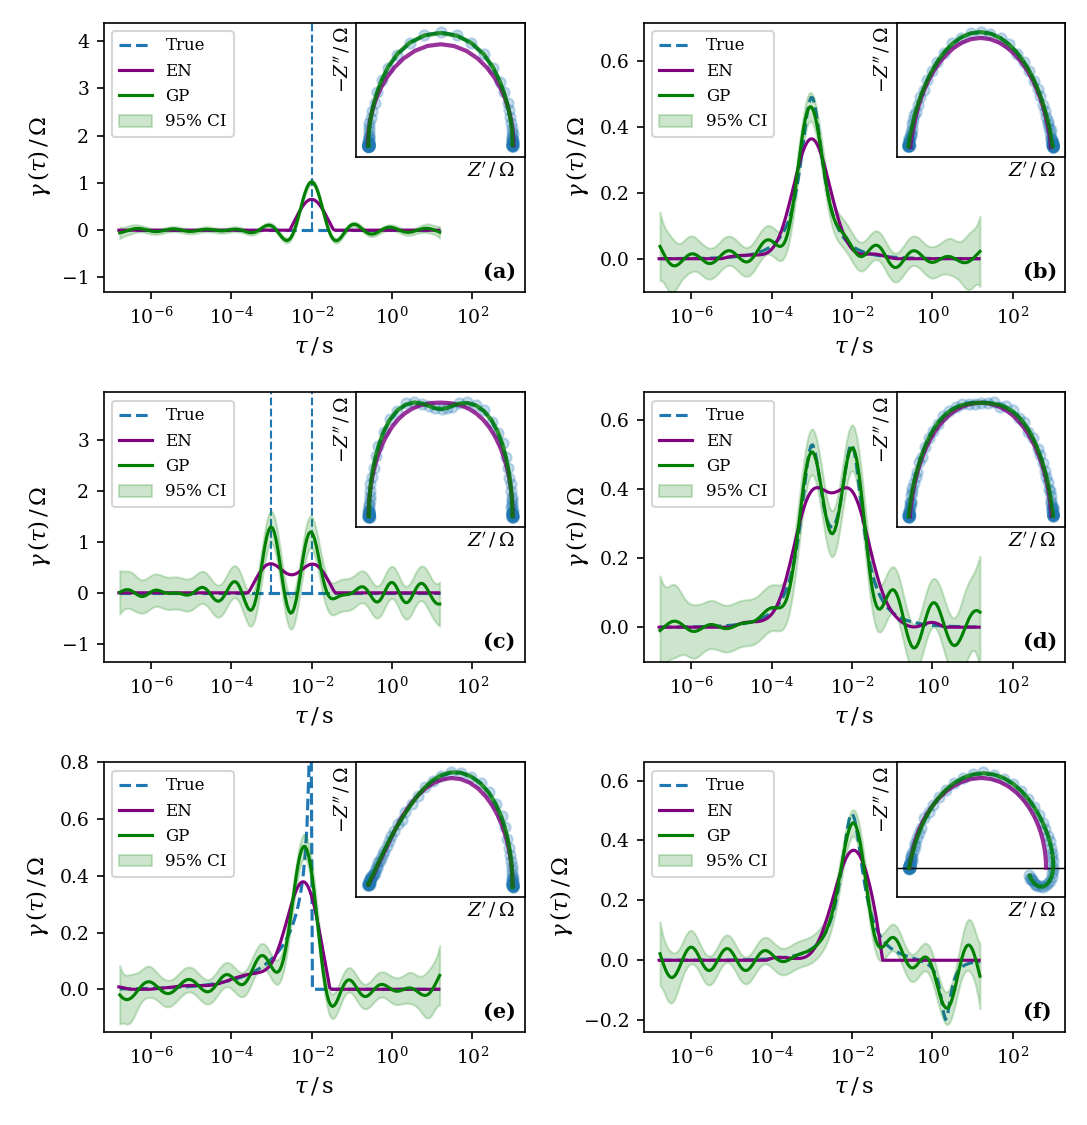

In [387]:
"Plot DRTs for all simulated spectra"

fig,axes_engp = plt.subplots(3,2,figsize=(7.25,7.5))#,sharex=True)

circuits = ['RC','ZARC','2RC','2ZARC','Gerischer','ZARC-RL']
err_model = 'uniform'
noise_level = 0.25

for n,(circ,ax) in enumerate(zip(circuits,axes_engp.ravel())):
    Z_file = os.path.join(data_path,'simulated',f'Z_{circ}_noiseless.csv')
    Zn_file = os.path.join(data_path,'simulated',f'Z_{circ}_{err_model}_{noise_level}.csv')
    # get results filenames
    fname = os.path.split(Zn_file)[1]
    suffix = fname[1:]
    Zout = f'Zout{suffix}'
    Gout = f'Gout{suffix}'
    
    # plot impedance data on inset
    axi = ax.inset_axes([0.6,0.5,0.4,0.5])
    Zdf = pd.read_csv(Z_file)
    Zndf = pd.read_csv(Zn_file)
    gt.plot_nyquist(Zdf,ax=axi,label='True',plot_func='plot',ls='--',label_size=tick_size)
    gt.plot_nyquist(Zndf,ax=axi,label='Data',s=25,alpha=0.25,label_size=tick_size)
    if circ=='ZARC-RL':
        axi.axhline(0,lw=0.7,c='k')
            
    # plot estimated DRT
    for model_name in ['EN','GP']:
        path = model_info[model_name]['path']
        color = model_info[model_name]['color']
        # load results
        Zres = pd.read_csv(os.path.join(path,Zout))
        Gres = pd.read_csv(os.path.join(path,Gout))
        # limit DRT range to data range to avoid large CIs on GP
        tmin = 1/(2*np.pi*Zdf['Freq'].max())
        tmax = 1/(2*np.pi*Zdf['Freq'].min())
        Gres = Gres[(Gres['tau']>= tmin) & (Gres['tau']<= tmax)]
        
        # plot DRT on appropriate axis
        if model_name=='GP':
            ax.plot(Gres['tau'],Gres['gamma'],label='GP',c=color)
            ax.fill_between(Gres['tau'],Gres['gamma']-Gres['sigma_gamma']*2,Gres['gamma']+Gres['sigma_gamma']*2,
                            alpha=0.2,label='95% CI',color=color,lw=1)
        elif model_name=='EN':
            ax.plot(Gres['tau'],Gres['gamma'],label='EN',c=color)
            
        # plot impedance fit
        if model_name=='GP':
            'GP does not predict Zreal. Use predicted Zimag with true Zreal'
            df = pd.read_csv(Z_file)
            Z_combo = df['Zreal'] + 1j*Zres['Zimag'].values[::-1]
            Zres = gt.construct_eis_df(df['Freq'],Z_combo.values)
        gt.plot_nyquist(Zres,ax=axi,plot_func='plot',label=model_name,c=color,lw=2,alpha=0.8,label_size=tick_size)
            
    ax.set_xscale('log')
    ax.set_xlabel(r'$\tau \, / \, $s',size=label_size)
    ax.set_ylabel(r'$\gamma\,(\tau) \, / \, \Omega$',size=label_size)
    ax.tick_params(labelsize=tick_size)
    ax.set_xlim(ax.get_xlim()[0],2e3)
    
    axi.set_xticks([])
    axi.set_yticks([])
    axi.get_legend().remove()
    axi.xaxis.set_label_coords(0.8,-0.025)
    axi.yaxis.set_label_coords(-0.025,0.72)
    
    # set axis limits to match hierarchical model plots
    ax.set_xlim(axes_bm.ravel()[n].get_xlim())
    ax.set_ylim(axes_bm.ravel()[n].get_ylim())
    
    # plot true DRT
    if circ=='RC':
        ax.axvline(1e-2,lw=1,ls='--',ymin=ax.transLimits.transform((1,0))[1],zorder=-10)
        ax.axhline(0,ls='--',zorder=-10,label='True',xmin=ax.transLimits.transform((np.log10(tmin),0))[0],
                  xmax=ax.transLimits.transform((np.log10(tmax),0))[0])
    elif circ=='2RC':
        ax.axvline(1e-2,lw=1,ls='--',ymin=ax.transLimits.transform((1,0))[1],zorder=-10)
        ax.axvline(1e-3,lw=1,ls='--',ymin=ax.transLimits.transform((1,0))[1],zorder=-10)
        ax.axhline(0,ls='--',zorder=-10,label='True',xmin=ax.transLimits.transform((np.log10(tmin),0))[0],
                  xmax=ax.transLimits.transform((np.log10(tmax),0))[0])
    else:
        g_file = os.path.join(data_path,'simulated',f'gamma_{circ}.csv')
        g_true = pd.read_csv(g_file)
        g_true = g_true[(g_true['tau']>= 1/(2*np.pi*Zdf['Freq'].max())) & (g_true['tau']<= 1/(2*np.pi*Zdf['Freq'].min()))]
        ax.plot(g_true['tau'],g_true['gamma'],label='True',ls='--',zorder=-10)
        
    # reorder legends
    h,l = ax.get_legend_handles_labels()
    srt_idx = [2,0,1,3]
    ax.legend(handles=[h[i] for i in srt_idx],labels=[l[i] for i in srt_idx],loc='upper left')
        
# subfigure labels
for n,ax in enumerate(axes_engp.ravel()):
    let = chr(n+97)
    ax.text(0.9,0.05,f'({let})',transform=ax.transAxes,fontweight='bold')
    
fig.tight_layout()
fig.savefig(os.path.join(plotdir,'DRTs_AllSimData_EnGp.jpg'),dpi=500)
fig.savefig(os.path.join(latexdir,'DRTs_AllSimData_EnGp.pdf'),dpi=500)

In [311]:
(ax.transLimits).transform((-6,0))

array([0.11189456, 0.26546329])

# Comparison figures: simulated data

In [341]:
def compare_drt_3x1(circ,err_model,noise_level,subfig_labels=True,axes=None,trunc_tau_plot=True):
    if axes is None:
        fig, axes = plt.subplots(3,1,figsize=(3.625,7.5),sharey=False)
    else:
        fig = axes[0].get_figure()
    
    # plot impedance data
    Z_file = os.path.join(data_path,'simulated',f'Z_{circ}_noiseless.csv')
    Zn_file = os.path.join(data_path,'simulated',f'Z_{circ}_{err_model}_{noise_level}.csv')
    Zdf = pd.read_csv(Z_file)
    Zndf = pd.read_csv(Zn_file)
    gt.plot_nyquist(Zdf,ax=axes[0],label='True',plot_func='plot',ls='--',label_size=label_size)
    gt.plot_nyquist(Zndf,ax=axes[0],label='Data',s=30,alpha=0.4,label_size=label_size)

    # share y axes for all DRT plots
    axes[1].get_shared_y_axes().join(axes[1],axes[2])

    # get results filenames
    fname = os.path.split(Zn_file)[1]
    suffix = fname[1:]
    Zout = f'Zout{suffix}'
    Gout = f'Gout{suffix}'

    # plot DRT and impedance fit for each model
    for i,(model_name,info) in enumerate(model_info.items()):
        path = info['path']
        color = info['color']
        Zres = pd.read_csv(os.path.join(path,Zout))
        Gres = pd.read_csv(os.path.join(path,Gout))
        if trunc_tau_plot:
            # limit DRT range to data range to avoid large CIs on GP
            tmin = 1/(2*np.pi*Zdf['Freq'].max())
            tmax = 1/(2*np.pi*Zdf['Freq'].min())
            Gres = Gres[(Gres['tau']>= tmin) & (Gres['tau']<= tmax)]

        # plot DRT on appropriate axis
        if model_name=='PM':
            axes[1].plot(Gres['tau'],Gres['gamma'],label='PM',c=color)
            axes[1].fill_between(Gres['tau'],Gres['gamma_lo'],Gres['gamma_hi'],alpha=0.15,label='95% CI',
                                   color=color,lw=1)
            "code below gives a graded fill - too hard to see"
#             dr = load_pickle(os.path.join(path,'obj{}.pkl'.format(suffix[:-4])))
#             num_fill = 50
#             for y in np.linspace(1,47.5,num_fill):
#                 glo = dr.drt(Gres['tau'],percentile=50-y)
#                 ghi = dr.drt(Gres['tau'],percentile=50+y)
#                 axes[1].fill_between(Gres['tau'],glo,ghi,alpha=1/num_fill,color=color,lw=0)
                
        elif model_name=='MAP':
            axes[1].plot(Gres['tau'],Gres['gamma'],label='MAP',c=color,ls='-',alpha=1)
        elif model_name=='GP':
            axes[2].plot(Gres['tau'],Gres['gamma'],c=color,label='GP')
            axes[2].fill_between(Gres['tau'],Gres['gamma']-2*Gres['sigma_gamma'],Gres['gamma']+2*Gres['sigma_gamma'],
                                alpha=0.2,color=color,label='95% CI',lw=1)
        else:
            axes[2].plot(Gres['tau'],Gres['gamma'],c=color,label=model_name)

        # plot fitted impedance
        if model_name=='PM':
            # parse complex numbers
            real_cols = ['freq','Zreal','Zimag']
            for col in real_cols:
                Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x))
                Zres[col] = np.real(Zres[col])
            imag_cols = ['Zlo','Zhi']
            for col in imag_cols:
                Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x))   
        gt.plot_nyquist(Zres,ax=axes[0],plot_func='plot',label=model_name,c=color,lw=2,alpha=0.6,label_size=label_size)

    for ax in axes.ravel()[1:]:
        ax.set_xscale('log')
        ax.set_xlabel(r'$\tau \, / \, $s',size=label_size)
        ax.set_ylabel(r'$\gamma\,(\tau) \, / \, \Omega$',size=label_size)

    for ax in axes.ravel():
        ax.tick_params(labelsize=tick_size)

    # reorder legend entries for Nyquist plot    
    h,l = axes[0].get_legend_handles_labels()
    srt_idx = [0,-1,1,2,3,4]
    axes[0].legend(handles=[h[idx] for idx in srt_idx],labels=[l[idx] for idx in srt_idx],
                     fontsize=tick_size-1)

    if circ=='Gerischer':
        axes[1].set_ylim(axes[1].get_ylim()[0],0.8)
        
    # plot true DRT
    if circ=='RC':
        ax.axvline(1e-2,lw=1,ls='--',ymin=ax.transLimits.transform((1,0))[1],zorder=-10)
        ax.axhline(0,ls='--',zorder=-10,label='True',xmin=ax.transLimits.transform((np.log10(tmin),0))[0],
                  xmax=ax.transLimits.transform((np.log10(tmax),0))[0])
    elif circ=='2RC':
        ax.axvline(1e-2,lw=1,ls='--',ymin=ax.transLimits.transform((1,0))[1],zorder=-10)
        ax.axvline(1e-3,lw=1,ls='--',ymin=ax.transLimits.transform((1,0))[1],zorder=-10)
        ax.axhline(0,ls='--',zorder=-10,label='True',xmin=ax.transLimits.transform((np.log10(tmin),0))[0],
                  xmax=ax.transLimits.transform((np.log10(tmax),0))[0])
    else:
        g_file = os.path.join(data_path,'simulated',f'gamma_{circ}.csv')
        g_true = pd.read_csv(g_file)
        if trunc_tau_plot:
            g_true = g_true[(g_true['tau']>= 1/(2*np.pi*Zdf['Freq'].max())) & 
                            (g_true['tau']<= 1/(2*np.pi*Zdf['Freq'].min()))
                           ]
        for ax in axes[1:]:
            ax.plot(g_true['tau'],g_true['gamma'],label='True',ls='--',zorder=-10)
            
    for ax in axes.ravel()[1:]:
        # reorder legends
        h,l = ax.get_legend_handles_labels()
        srt_idx = [2,0,1,3]
        ax.legend(handles=[h[i] for i in srt_idx],labels=[l[i] for i in srt_idx],loc='upper left')
        
    # subfigure labels
    if subfig_labels:
        for n,ax in enumerate(axes.ravel()):
            let = chr(n+97)
            ax.text(0.9,0.9,f'({let})',transform=ax.transAxes,fontweight='bold')

    fig.tight_layout()
    return fig, axes

C:\Users\jdh10\anaconda3\envs\stan\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


<IPython.core.display.Javascript object>


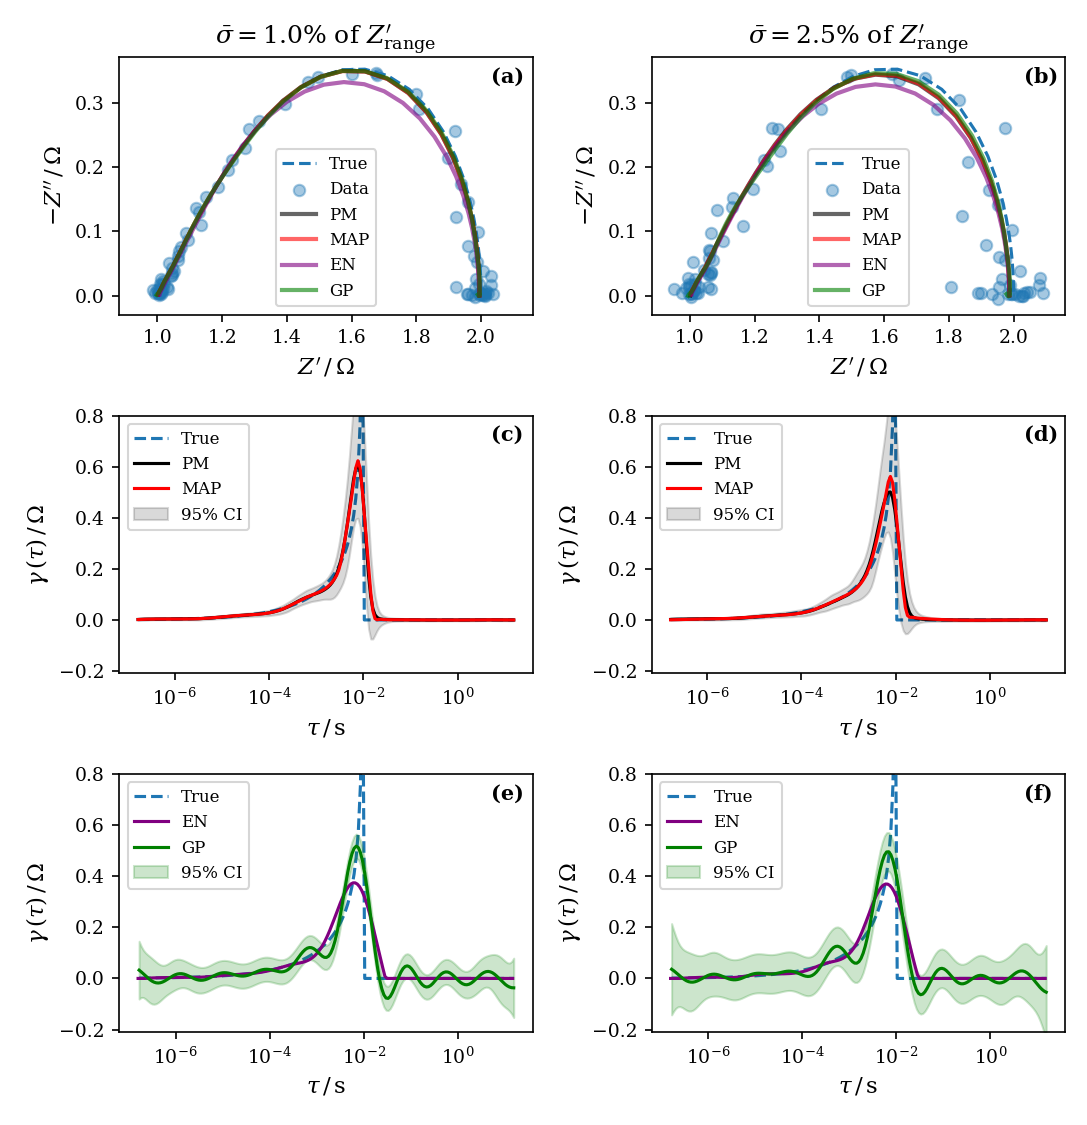

In [388]:
circ = 'Gerischer'
err_model = 'Macdonald'
noise_levels = [1.0,2.5]

fig,axes = plt.subplots(3,2,figsize=(7.25,7.5))
# set same x and ylim for all Nyquist plots
axes[0,0].get_shared_x_axes().join(axes[0,0],axes[0,1])
axes[0,0].get_shared_y_axes().join(axes[0,0],axes[0,1])
# set same ylim for all DRT plots
axes[1,0].get_shared_y_axes().join(axes[1,0],axes[1,1],axes[2,0],axes[2,1])

for i,noise_level in enumerate(noise_levels):
    f,a = compare_drt_3x1(circ,err_model,noise_level,axes=axes[:,i],subfig_labels=False)
    axes[0,i].set_title(fr'$\bar{{\sigma}}={noise_level}$% of $Z^\prime_{{\mathrm{{range}}}}$')
    
# subfigure labels
for n,ax in enumerate(axes.ravel()):
    let = chr(n+97)
    ax.text(0.9,0.9,f'({let})',transform=ax.transAxes,fontweight='bold')
    
suffix = f'_{circ}_{err_model}_1.0-2.5'
fig.savefig(os.path.join(plotdir,f'DrtComparison{suffix}.jpg'),dpi=500)
fig.savefig(os.path.join(latexdir,f'DrtComparison{suffix}.pdf'),dpi=500)

C:\Users\jdh10\anaconda3\envs\stan\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


<IPython.core.display.Javascript object>


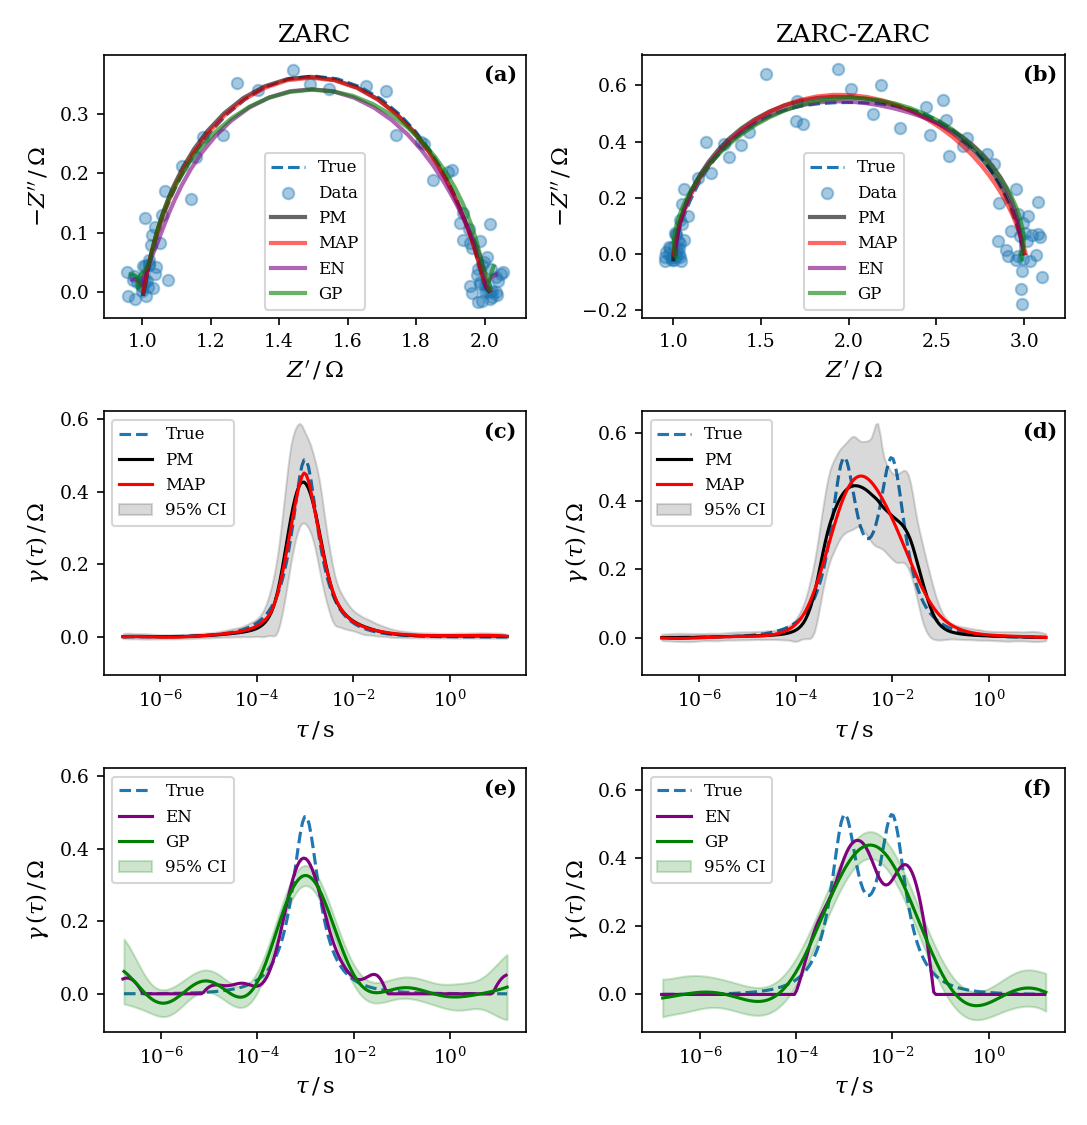

In [389]:
circs = ['ZARC','2ZARC']
err_models = ['uniform','Orazem']
noise_level = 2.5

fig,axes = plt.subplots(3,2,figsize=(7.25,7.5))
# set same x and ylim for all Nyquist plots
# axes[0,0].get_shared_x_axes().join(axes[0,0],axes[0,1])
# axes[0,0].get_shared_y_axes().join(axes[0,0],axes[0,1])

# axes[1,0].get_shared_y_axes().join(axes[1,0],axes[1,1],axes[2,0],axes[2,1])

for i,(circ,err_model) in enumerate(zip(circs,err_models)):
    f,a = compare_drt_3x1(circ,err_model,noise_level,axes=axes[:,i],subfig_labels=False)
#     axes[0,i].set_title(fr'$\bar{{\sigma}}={noise_level}$% of $Z^\prime_{{\mathrm{{range}}}}$')
    # set same ylim for each DRT plots
    axes[1,i].get_shared_y_axes().join(axes[1,i],axes[2,i])
    
axes[0,0].set_title('ZARC')
axes[0,1].set_title('ZARC-ZARC')
fig.tight_layout()
    
# subfigure labels
for n,ax in enumerate(axes.ravel()):
    let = chr(n+97)
    ax.text(0.9,0.9,f'({let})',transform=ax.transAxes,fontweight='bold')
    
fig.savefig(os.path.join(plotdir,f'DrtComparison_ZARC-2ZARC_2.5.jpg'),dpi=500)
fig.savefig(os.path.join(latexdir,f'DrtComparison_ZARC-2ZARC_2.5.pdf'),dpi=500)

<IPython.core.display.Javascript object>


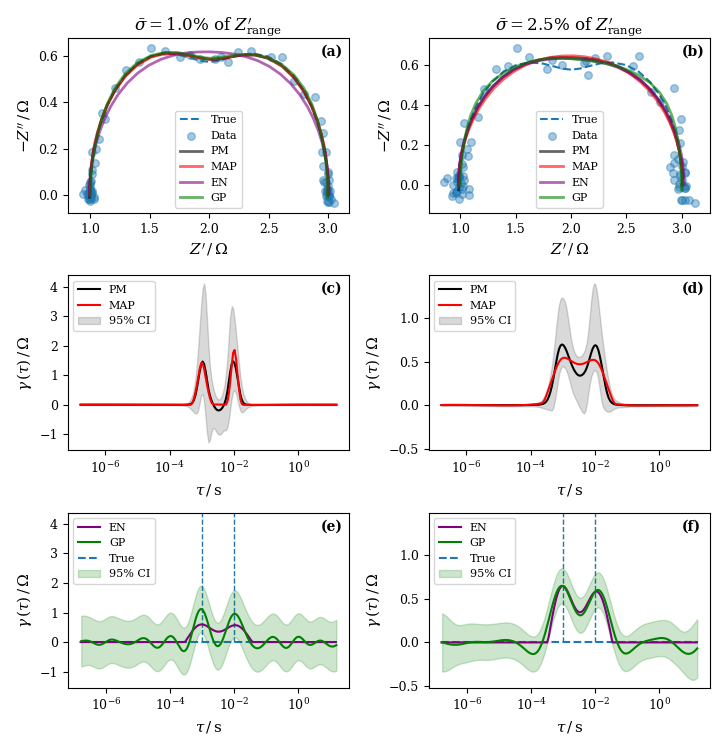

In [319]:
circ = '2RC'
err_model = 'uniform'
noise_levels = [1.0,2.5]

fig,axes = plt.subplots(3,2,figsize=(7.25,7.5))
# set same x and ylim for all Nyquist plots
# axes[0,0].get_shared_x_axes().join(axes[0,0],axes[0,1])
# axes[0,0].get_shared_y_axes().join(axes[0,0],axes[0,1])
# set same ylim for all DRT plots
# axes[1,0].get_shared_y_axes().join(axes[1,0],axes[1,1],axes[2,0],axes[2,1])

for i,noise_level in enumerate(noise_levels):
    f,a = compare_drt_3x1(circ,err_model,noise_level,axes=axes[:,i],subfig_labels=False)
    axes[0,i].set_title(fr'$\bar{{\sigma}}={noise_level}$% of $Z^\prime_{{\mathrm{{range}}}}$')
    
# subfigure labels
for n,ax in enumerate(axes.ravel()):
    let = chr(n+97)
    ax.text(0.9,0.9,f'({let})',transform=ax.transAxes,fontweight='bold')
    
suffix = f'_{circ}_{err_model}_1.0-2.5'
# fig.savefig(os.path.join(plotdir,f'DrtComparison{suffix}.jpg'),dpi=500)
# fig.savefig(os.path.join(latexdir,f'DrtComparison{suffix}.jpg'),dpi=500)

C:\Users\jdh10\anaconda3\envs\stan\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


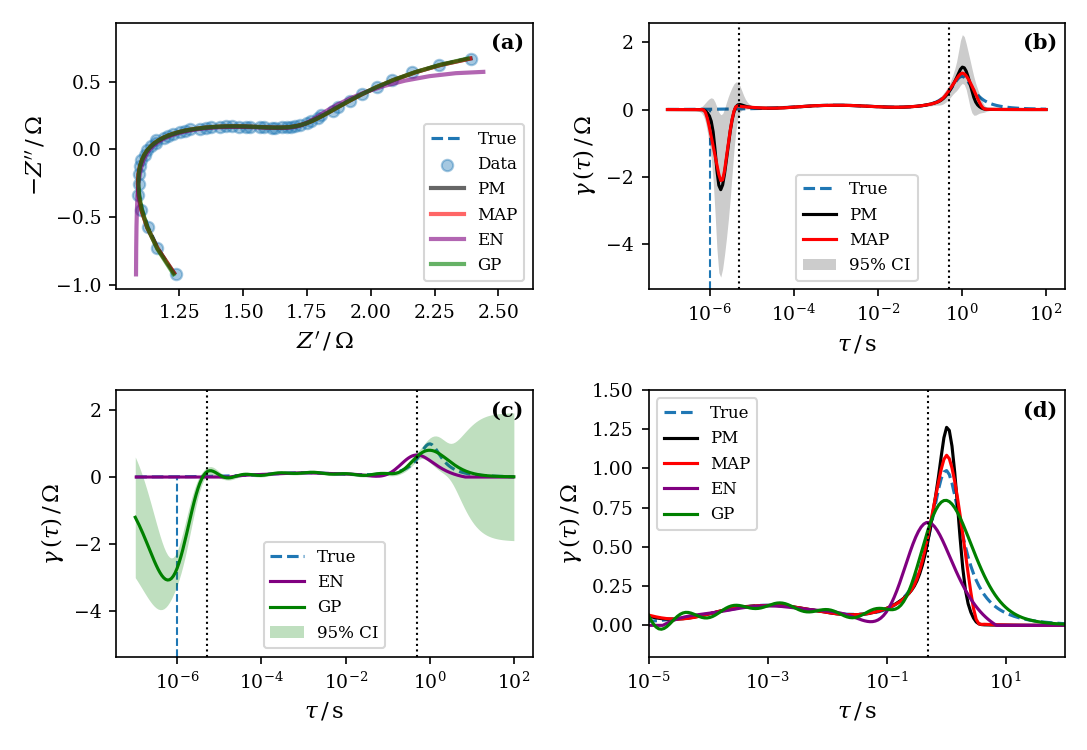

In [390]:
circ = 'trunc'
err_model = 'Macdonald'
noise_level = 0.25
# suffix = f'_{circ}_{err_model}_{noise_level}'

fig,axes = plt.subplots(2,2,figsize=(7.25,5))

# plot impedance data
Z_file = os.path.join(data_path,'simulated',f'Z_{circ}_noiseless.csv')
Zn_file = os.path.join(data_path,'simulated',f'Z_{circ}_{err_model}_{noise_level}.csv')
Zdf = pd.read_csv(Z_file)
Zndf = pd.read_csv(Zn_file)
gt.plot_nyquist(Zdf,ax=axes[0,0],label='True',plot_func='plot',ls='--',label_size=label_size)
gt.plot_nyquist(Zndf,ax=axes[0,0],label='Data',s=30,alpha=0.4,label_size=label_size)

# share y axes for non-zoomed DRT plots
axes[0,1].get_shared_y_axes().join(axes[0,1],axes[1,0])
axes[0,1].get_shared_x_axes().join(axes[0,1],axes[1,0])

# get results filenames
fname = os.path.split(Zn_file)[1]
suffix = fname[1:]
Zout = f'Zout{suffix}'
Gout = f'Gout{suffix}'

# plot DRT and impedance fit for each model
for i,(model_name,info) in enumerate(model_info.items()):
    path = info['path']
    color = info['color']
    Zres = pd.read_csv(os.path.join(path,Zout))
    Gres = pd.read_csv(os.path.join(path,Gout))
    # limit DRT range to data range to avoid large CIs on GP
#     Gres = Gres[(Gres['tau']>= 1/(2*np.pi*Zdf['Freq'].max())) & (Gres['tau']<= 1/(2*np.pi*Zdf['Freq'].min()))]

    # plot DRT on appropriate axis
    if model_name=='PM':
        for ax in (axes[0,1],axes[1,1]):
            ax.plot(Gres['tau'],Gres['gamma'],label='PM',c=color)
        axes[0,1].fill_between(Gres['tau'],Gres['gamma_lo'],Gres['gamma_hi'],alpha=0.2,label='95% CI',
                               color=color,lw=0)
    elif model_name=='MAP':
        for ax in (axes[0,1],axes[1,1]):
            ax.plot(Gres['tau'],Gres['gamma'],label='MAP',c=color,ls='-',alpha=1)
    elif model_name=='GP':
        for ax in (axes[1,0],axes[1,1]):
            ax.plot(Gres['tau'],Gres['gamma'],c=color,label='GP')
        axes[1,0].fill_between(Gres['tau'],Gres['gamma']-3*Gres['sigma_gamma'],Gres['gamma']+3*Gres['sigma_gamma'],
                            alpha=0.25,color=color,label='95% CI',lw=0)
    else:
        for ax in (axes[1,0],axes[1,1]):
            ax.plot(Gres['tau'],Gres['gamma'],c=color,label=model_name)

    # plot fitted impedance
    if model_name=='PM':
        # parse complex numbers
        real_cols = ['freq','Zreal','Zimag']
        for col in real_cols:
            Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x))
            Zres[col] = np.real(Zres[col])
        imag_cols = ['Zlo','Zhi']
        for col in imag_cols:
            Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x))
        
    gt.plot_nyquist(Zres,ax=axes[0,0],plot_func='plot',label=model_name,c=color,lw=2,alpha=0.6,label_size=label_size)

# formatting
for ax in axes.ravel()[1:]:
    ax.set_xscale('log')
    ax.set_xlabel(r'$\tau \, / \, $s')
    ax.set_ylabel(r'$\gamma\,(\tau) \, / \, \Omega$')

# make room for subfig label
axes[0,0].set_xlim(axes[0,0].get_xlim()[0],axes[0,0].get_xlim()[1]*1.05)
axes[0,0].set_ylim(axes[0,0].get_ylim()[0],axes[0,0].get_ylim()[1]*1.2)
# axes[1,0].set_xlim(axes[1,0].get_xlim()[0]/1.2,axes[1,0].get_xlim()[1]*1.2)


# reorder legend entries for Nyquist plot    
h,l = axes[0,0].get_legend_handles_labels()
srt_idx = [0,-1,1,2,3,4]
axes[0,0].legend(handles=[h[idx] for idx in srt_idx],labels=[l[idx] for idx in srt_idx],
                 loc='lower right')

# zoom in on ZARCs on 4th axis
axes[1,1].set_xlim(1e-5,1e2)
axes[1,1].set_ylim(-0.2,1.5)


# plot true DRT
g_file = os.path.join(data_path,'simulated',f'gamma_{circ}.csv')
g_true = pd.read_csv(g_file)
for ax in axes.ravel()[1:]:
    p = ax.plot(g_true['tau'],g_true['gamma'],label='True',ls='--',zorder=-10)
#     ax.plot(g_true['tau'],g_true['gamma'],ls='-',alpha=0.15,lw=6,zorder=-10,c=p[0].get_color())
    ax.axvline(1e-6,lw=1,ls='--',ymax=ax.transLimits.transform((1,0))[1],zorder=-10)
    ax.axvline(1/(2*np.pi*Zdf['Freq'].min()),ls=':',c='k',lw=1)
    ax.axvline(1/(2*np.pi*Zdf['Freq'].max()),ls=':',c='k',lw=1)
    # reorder legends
    h,l = ax.get_legend_handles_labels()
    if ax==axes[1,1]:
        srt_idx = [4,0,1,2,3]
    else:
        srt_idx = [2,0,1,3]
    ax.legend(handles=[h[i] for i in srt_idx],labels=[l[i] for i in srt_idx])

# subfigure labels
for n,ax in enumerate(axes.ravel()):
    let = chr(n+97)
    ax.text(0.9,0.9,f'({let})',transform=ax.transAxes,fontweight='bold')

fig.tight_layout()

suffix = f'_{circ}_{err_model}_{noise_level}'
fig.savefig(os.path.join(plotdir,f'DrtComparison{suffix}.jpg'),dpi=500)
fig.savefig(os.path.join(latexdir,f'DrtComparison{suffix}.pdf'),dpi=500)

# Comparison figures: experimental data

In [361]:
def plot_ecm_fit(Zdf,ecm_param_file,g_file,ec_model):
    "Generate plot of ECM fit and ECM DRT only"
    fig, axes = plt.subplots(1,2,figsize=(7.25,3))

    ecm_params = load_pickle(ecm_param_file)   
    g_ref = pd.read_csv(g_file)

    # get impedance scale
    unit_scale = gt.get_unit_scale(Zdf)
    unit_map = {-2:'$\mu$',-1:'m',0:'',1:'k',2:'M',3:'G'}
    rev_map = {v:k for k,v in unit_map.items()}
    scale_factor = 10**(3*rev_map[unit_scale])
    
    # plot nyquist
    gt.plot_nyquist(Zdf,ax=axes[0],label='Data',s=20,alpha=0.25,unit_scale=unit_scale)
#     default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    gt.plot_model(ec_model,ecm_params,w=Zdf['Freq'],axes=axes[0],plot_type='nyquist',label='ECM',unit_scale=unit_scale)
#                  mark_peaks=True,c=default_colors[0])

    # reorder legend items
    h,l = axes[0].get_legend_handles_labels()
    axes[0].legend(handles=h[::-1],labels=l[::-1])
    
    # plot DRT from ECM
    axes[1].plot(g_ref['tau'],g_ref['gamma']/scale_factor,label='ECM')
    axes[1].set_xscale('log')
    axes[1].set_xlabel(r'$\tau$ / s')
    axes[1].set_ylabel(f'$\gamma \ / \ {unit_scale}\Omega$')
    
    # plot measurement boundaries
    axes[1].axvline(1/(2*np.pi*Zdf['Freq'].min()),ls=':',c='k',lw=1)
    axes[1].axvline(1/(2*np.pi*Zdf['Freq'].max()),ls=':',c='k',lw=1)
    
    # subfigure labels
    for n,ax in enumerate(axes.ravel()):
        let = chr(n+97)
        ax.text(0.9,0.9,f'({let})',transform=ax.transAxes,fontweight='bold')

    fig.tight_layout()
    
    return fig, axes

In [362]:
def compare_drt_3x1_exp(Zndf,Zecm_file,g_file,suffix,subfig_labels=True,axes=None,trunc_tau_plot=False):
    "Generate plots of impedance fit and DRTs for all models"
    if axes is None:
        fig, axes = plt.subplots(3,1,figsize=(3.625,7.5),sharey=False)
    else:
        fig = axes[0].get_figure()
    
    # plot impedance data
    gt.plot_nyquist(Zndf,ax=axes[0],label='Data',s=30,alpha=0.4,label_size=label_size)
    # plot ECM fit
    df_ecm = pd.read_csv(Zecm_file)
    gt.plot_nyquist(df_ecm,ax=axes[0],label='ECM',plot_func='plot',ls='--',label_size=label_size)
    
    # get impedance scale
    unit_scale = gt.get_unit_scale(Zndf)
    unit_map = {-2:'$\mu$',-1:'m',0:'',1:'k',2:'M',3:'G'}
    rev_map = {v:k for k,v in unit_map.items()}
    scale_factor = 10**(3*rev_map[unit_scale])
    
    # plot reference DRT from ECM
    g_true = pd.read_csv(g_file)
    g_true['gamma'] /= scale_factor
    if trunc_tau_plot:
        g_true = g_true[(g_true['tau']>= 1/(2*np.pi*Zdf['Freq'].max())) & 
                        (g_true['tau']<= 1/(2*np.pi*Zdf['Freq'].min()))
                       ]
    for ax in axes[1:]:
        ax.plot(g_true['tau'],g_true['gamma'],label='ECM',ls='--')
        # plot measurement boundaries
        ax.axvline(1/(2*np.pi*Zndf['Freq'].min()),ls=':',c='k',lw=1)
        ax.axvline(1/(2*np.pi*Zndf['Freq'].max()),ls=':',c='k',lw=1)

    # share y axes for all DRT plots
    axes[1].get_shared_y_axes().join(axes[1],axes[2])

    # get results filenames
    Zout = f'Zout{suffix}'
    Gout = f'Gout{suffix}'

    # plot DRT and impedance fit for each model
    for i,(model_name,info) in enumerate(model_info.items()):
        path = info['path']
        color = info['color']
        Zres = pd.read_csv(os.path.join(path,Zout))
        Gres = pd.read_csv(os.path.join(path,Gout))
        
        if trunc_tau_plot:
            # limit DRT range to data range to avoid large CIs on GP
            Gres = Gres[(Gres['tau']>= 1/(2*np.pi*Zdf['Freq'].max())) & (Gres['tau']<= 1/(2*np.pi*Zdf['Freq'].min()))]
        scale_cols = ['gamma','gamma_lo','gamma_hi','sigma_gamma']
        for col in scale_cols:
            try:
                Gres[col] /= scale_factor
            except KeyError:
                pass
        # plot DRT on appropriate axis
        if model_name=='PM':
            axes[1].plot(Gres['tau'],Gres['gamma'],label='PM',c=color)
            axes[1].fill_between(Gres['tau'],Gres['gamma_lo'],Gres['gamma_hi'],alpha=0.15,label='95% CI',
                                   color=color,lw=1)
        elif model_name=='MAP':
            axes[1].plot(Gres['tau'],Gres['gamma'],label='MAP',c=color,ls='-',alpha=1)
        elif model_name=='GP':
            axes[2].plot(Gres['tau'],Gres['gamma'],c=color,label='GP')
            axes[2].fill_between(Gres['tau'],Gres['gamma']-2*Gres['sigma_gamma'],Gres['gamma']+2*Gres['sigma_gamma'],
                                alpha=0.2,color=color,label='95% CI',lw=1)
        else:
            axes[2].plot(Gres['tau'],Gres['gamma'],c=color,label=model_name)

        # plot fitted impedance
        if model_name=='PM':
            # parse complex numbers
            real_cols = ['freq','Zreal','Zimag']
            for col in real_cols:
                Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x))
                Zres[col] = np.real(Zres[col])
            imag_cols = ['Zlo','Zhi']
            for col in imag_cols:
                Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x))  
        gt.plot_nyquist(Zres,ax=axes[0],plot_func='plot',label=model_name,c=color,lw=2,alpha=0.6,label_size=label_size)

    for ax in axes.ravel()[1:]:
        ax.set_xscale('log')
        ax.legend(fontsize=tick_size-1,loc='upper left')
        ax.set_xlabel(r'$\tau \, / \, $s',size=label_size)
        ax.set_ylabel(fr'$\gamma\,(\tau) \, / \, \mathrm{{{unit_scale}}}\Omega$',size=label_size)

    for ax in axes.ravel():
        ax.tick_params(labelsize=tick_size)

    # reorder legend entries for Nyquist plot    
    h,l = axes[0].get_legend_handles_labels()
    srt_idx = [-1,0,1,2,3,4]
    axes[0].legend(handles=[h[idx] for idx in srt_idx],labels=[l[idx] for idx in srt_idx],
                     fontsize=tick_size-1)
        
    # subfigure labels
    if subfig_labels:
        for n,ax in enumerate(axes.ravel()):
            let = chr(n+97)
            ax.text(0.9,0.9,f'({let})',transform=ax.transAxes,fontweight='bold')

    fig.tight_layout()
    return fig, axes

## LIB

<IPython.core.display.Javascript object>


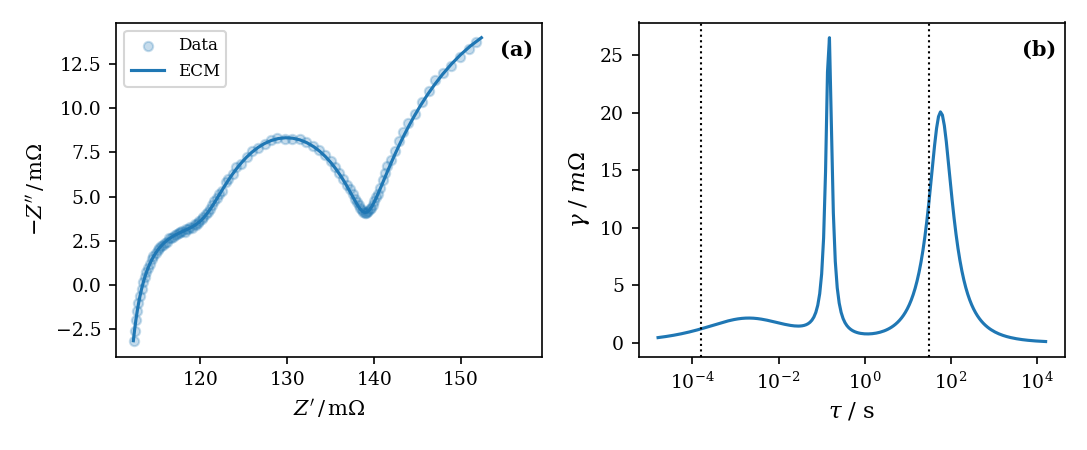

In [180]:
Z_file = '../data/experimental/DRTtools_LIB_data.txt'
Zdf = pd.read_csv(Z_file,sep='\t',header=None)
Zdf = pd.DataFrame(Zdf.values,columns=['Freq','Zreal','Zimag'])

ecm_param_file = '../data/experimental/EcmParams_LIB.pkl'
g_file = '../data/experimental/gamma_LIB_ECM.csv'

ec_model = gt.Z_var_num_RC

fig,axes = plot_ecm_fit(Zdf,ecm_param_file,g_file,ec_model)
# make room for subfig label
axes[0].set_xlim(axes[0].get_xlim()[0],axes[0].get_xlim()[1]+5)

fig.savefig(os.path.join(plotdir,'EcmFit_LIB.jpg'),dpi=500)
fig.savefig(os.path.join(latexdir,'EcmFit_LIB.pdf'),dpi=500)

In [124]:
gt.plot_model?

<IPython.core.display.Javascript object>


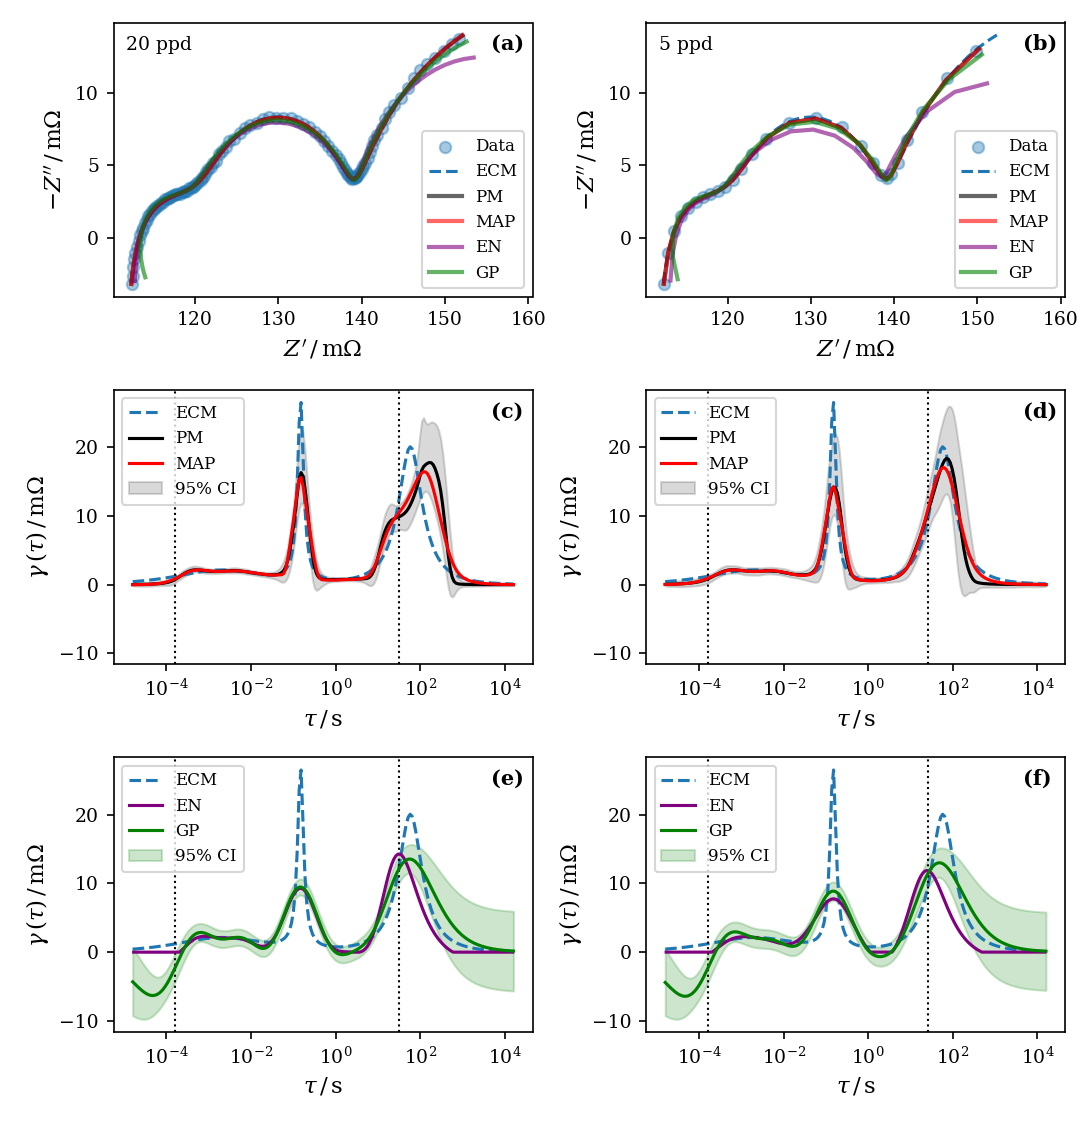

In [351]:
# full dataset
Z_file = '../data/experimental/DRTtools_LIB_data.txt'
Zdf = pd.read_csv(Z_file,sep='\t',header=None)
Zdf = pd.DataFrame(Zdf.values,columns=['Freq','Zreal','Zimag'])

# 1/4 ppd
Zq_file = '../data/experimental/DRTtools_LIB_data_qtr.csv'
Zqdf = pd.read_csv(Zq_file)

Zecm_file = '../data/experimental/Z_ECM_LIB.csv'
g_file = '../data/experimental/gamma_LIB_ECM.csv'
suffixes = ['_LIB_data.csv','_LIB_data_qtr.csv']

fig,axes = plt.subplots(3,2,figsize=(7.25,7.5))

for i,(df,suffix) in enumerate(zip([Zdf,Zqdf],suffixes)):
    compare_drt_3x1_exp(df,Zecm_file,g_file,suffix,axes=axes[:,i],subfig_labels=False)
    
# formatting
#-----------
# same axis limits for Nyquist plots
axes[0,0].get_shared_x_axes().join(axes[0,0],axes[0,1])
axes[0,0].get_shared_y_axes().join(axes[0,0],axes[0,1])

# same axis limits for DRT plots
axes[1,0].get_shared_x_axes().join(axes[1,0],axes[1,1],axes[2,0],axes[2,1])
axes[1,0].get_shared_y_axes().join(axes[1,0],axes[1,1],axes[2,0],axes[2,1])

# make room for subfig labels
axes[0,0].set_xlim(axes[0,0].get_xlim()[0],axes[0,0].get_xlim()[1]+5)

axes[0,0].text(0.03,0.9,'20 ppd',transform=axes[0,0].transAxes,size=tick_size)
axes[0,1].text(0.03,0.9,'5 ppd',transform=axes[0,1].transAxes,size=tick_size)

# subfigure labels
for n,ax in enumerate(axes.ravel()):
    let = chr(n+97)
    ax.text(0.9,0.9,f'({let})',transform=ax.transAxes,fontweight='bold')   
    
fig.savefig(os.path.join(plotdir,'DrtComparison_LIB.jpg'),dpi=500)
fig.savefig(os.path.join(latexdir,'DrtComparison_LIB.pdf'),dpi=500)

C:\Users\jdh10\anaconda3\envs\stan\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


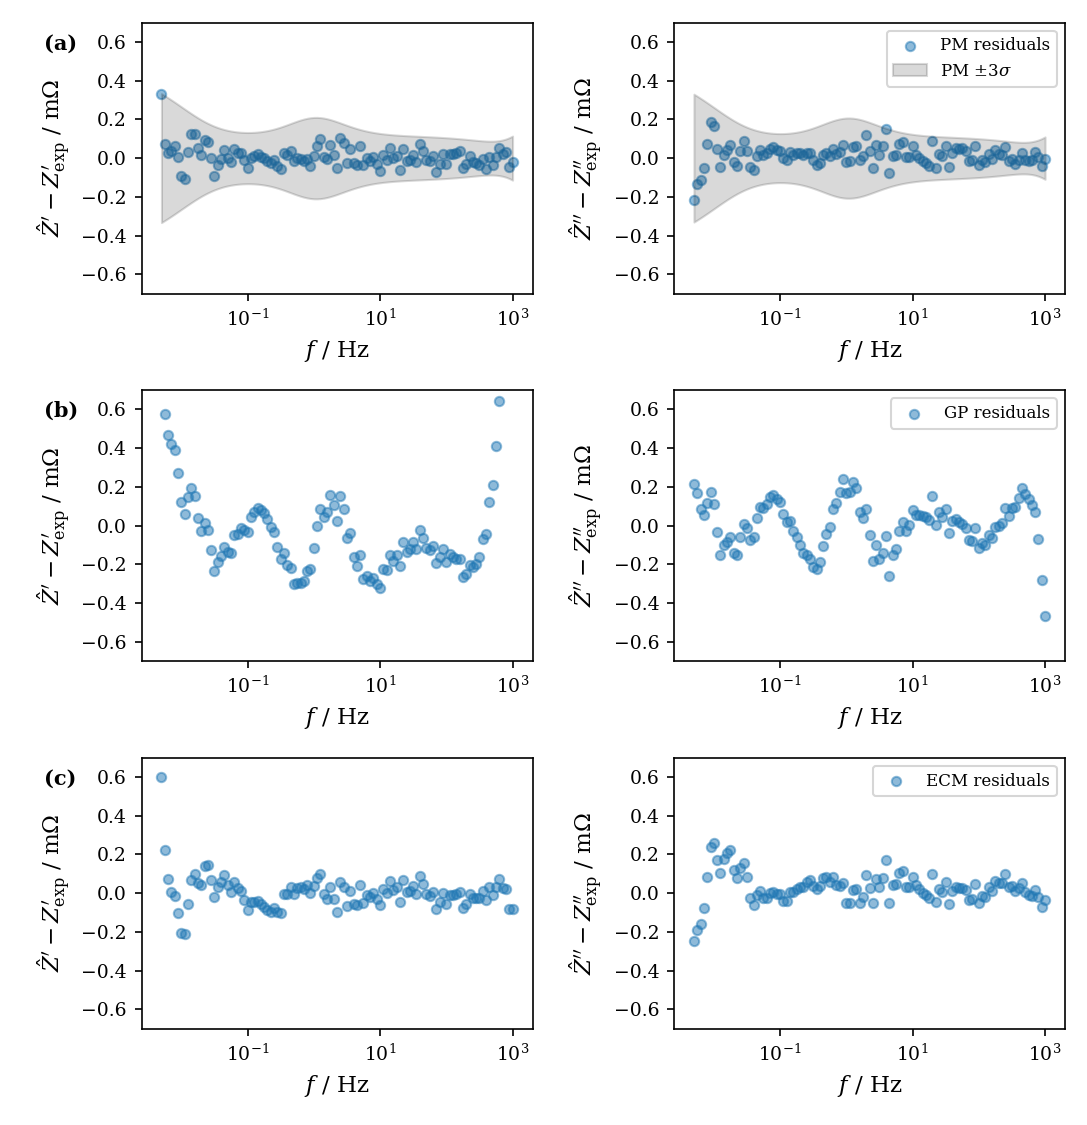

In [357]:
# plot residuals for full dataset for ECM, PM, and GP
fig,axes = plt.subplots(3,2,figsize=(7.25,7.5))

Z_file = '../data/experimental/DRTtools_LIB_data.txt'
suffix = '_LIB_data'
Zdf = pd.read_csv(Z_file,sep='\t',header=None)
Zdf = pd.DataFrame(Zdf.values,columns=['Freq','Zreal','Zimag'])
freq = Zdf['Freq'].values

# scatter formatting
scat_kw = {'s':20,'alpha':0.5}

# PM and GP
for axrow,model_name in zip(axes[:2,:],['PM','GP']):
    Zres = pd.read_csv(os.path.join(model_info[model_name]['path'],f'Zout{suffix}.csv'))
    if model_name=='PM':
        # parse complex numbers
        real_cols = ['freq','Zreal','Zimag']
        for col in real_cols:
            Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x))
            Zres[col] = np.real(Zres[col])
        imag_cols = ['Zlo','Zhi']
        for col in imag_cols:
            Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x))
            
    axrow[0].scatter(freq,(Zres['Zreal']-Zdf['Zreal'])*1000,label=fr'{model_name} residuals',**scat_kw)
    axrow[1].scatter(freq,(Zres['Zimag']-Zdf['Zimag'])*1000,label=fr'{model_name} residuals',**scat_kw)
    
    # GP error scale
#     if model_name=='GP':
#         axrow[1].fill_between(freq,-3e3*Zres['sigma_im'],3e3*Zres['sigma_im'],alpha=0.15,color='g',lw=1,
#                               label='GP $\pm 3 \sigma$')

# ECM residuals
Zecm_file = '../data/experimental/Z_ECM_LIB.csv'
ecm_df = pd.read_csv(Zecm_file)
axes[2,0].scatter(freq,(ecm_df['Zreal']-Zdf['Zreal'])*1000,label=r'ECM residuals',**scat_kw)
axes[2,1].scatter(freq,(ecm_df['Zimag']-Zdf['Zimag'])*1000,label=r'ECM residuals',**scat_kw)

# PM error scale
dr_mcmc = load_pickle(os.path.join(model_info['PM']['path'],f'obj{suffix}.pkl'))
sigma_re,sigma_im = dr_mcmc.predict_err_scale(Zdf['Freq'].values)
axes[0,0].fill_between(freq,-3e3*sigma_re,3e3*sigma_re,alpha=0.15,color='k',lw=1,label='3$\sigma^\prime$')
axes[0,1].fill_between(freq,-3e3*sigma_im,3e3*sigma_im,alpha=0.15,color='k',lw=1,label='PM $\pm 3 \sigma$')
        
# formatting
for ax in axes.ravel():
    ax.set_xscale('log')
    ax.set_ylim(-7e-1,7e-1)
    ax.set_xlim(np.min(freq)/2,np.max(freq)*2)
    ax.set_xlabel('$f$ / Hz')
    
for n,ax in enumerate(axes[:,0]):
    ax.set_ylabel('$\hat{Z}^\prime - Z^\prime_{\mathrm{exp}}$ / m$\Omega$')
    let = chr(n+97)
    ax.text(-0.25,0.9,f'({let})',transform=ax.transAxes,fontweight='bold')   
    h,l = ax.get_legend_handles_labels()
#     ax.legend(handles=h[::-1],labels=l[::-1],loc='upper right')
    
for ax in axes[:,1]:
    ax.set_ylabel('$\hat{Z}^{\prime\prime} - Z^{\prime\prime}_{\mathrm{exp}}$ / m$\Omega$')
    h,l = ax.get_legend_handles_labels()
    ax.legend(loc='upper right')
    
fig.tight_layout()
fig.savefig(os.path.join(plotdir,'Residuals_LIB.jpg'),dpi=500)
fig.savefig(os.path.join(latexdir,'Residuals_LIB.pdf'),dpi=500)

In [356]:
Zres

freq     Zreal     Zimag      sigma_im
0    999.040405  0.114016  0.002719  6.055093e-08
1    891.425842  0.113811  0.002326  4.148770e-08
2    794.237671  0.113649  0.001925  2.945547e-08
3    707.509460  0.113532  0.001525  2.256016e-08
4    631.009521  0.113461  0.001134  1.906760e-08
..          ...       ...       ...           ...
102    0.007927  0.148272 -0.011888  1.914296e-08
103    0.007064  0.149282 -0.012352  2.282466e-08
104    0.006296  0.150346 -0.012783  2.981226e-08
105    0.005612  0.151457 -0.013175  4.180568e-08
106    0.005001  0.152617 -0.013526  6.106839e-08

[107 rows x 4 columns]

<IPython.core.display.Javascript object>


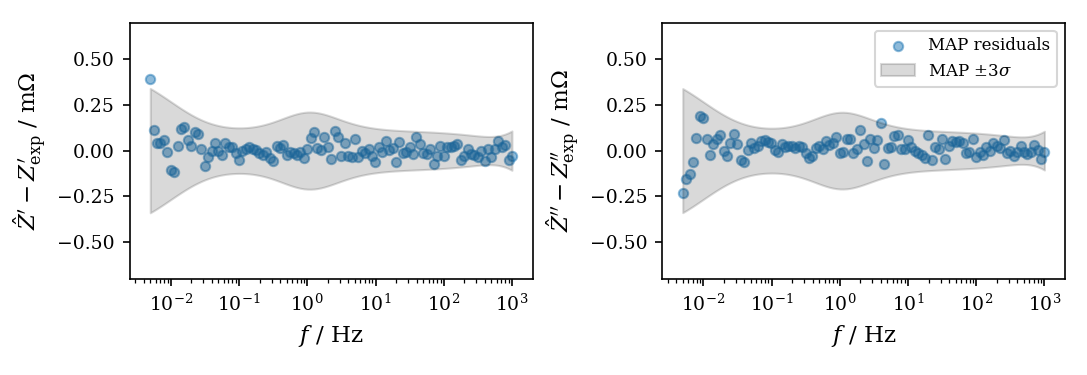

In [226]:
# plot residuals for full dataset for ECM, MAP, and GP
fig,axes = plt.subplots(1,2,figsize=(7.25,2.5))

Z_file = '../data/experimental/DRTtools_LIB_data.txt'
suffix = '_LIB_data'
Zdf = pd.read_csv(Z_file,sep='\t',header=None)
Zdf = pd.DataFrame(Zdf.values,columns=['Freq','Zreal','Zimag'])
freq = Zdf['Freq'].values

# scatter formatting
scat_kw = {'s':20,'alpha':0.5}

# MAP residuals
Zres = pd.read_csv(os.path.join(model_info['MAP']['path'],f'Zout{suffix}.csv'))
axes[0].scatter(freq,(Zres['Zreal']-Zdf['Zreal'])*1000,label=fr'MAP residuals',**scat_kw)
axes[1].scatter(freq,(Zres['Zimag']-Zdf['Zimag'])*1000,label=fr'MAP residuals',**scat_kw)

#  error scale
dr_mcmc = load_pickle(os.path.join(model_info['MAP']['path'],f'obj{suffix}.pkl'))
sigma_re,sigma_im = dr_mcmc.predict_err_scale(Zdf['Freq'].values)
axes[0].fill_between(freq,-3e3*sigma_re,3e3*sigma_re,alpha=0.15,color='k',lw=1,label='3$\sigma^\prime$')
axes[1].fill_between(freq,-3e3*sigma_im,3e3*sigma_im,alpha=0.15,color='k',lw=1,label='MAP $\pm 3 \sigma$')
        
# formatting
for ax in axes.ravel():
    ax.set_xscale('log')
    ax.set_ylim(-7e-1,7e-1)
    ax.set_xlim(np.min(freq)/2,np.max(freq)*2)
    ax.set_xlabel('$f$ / Hz')
    

axes[0].set_ylabel('$\hat{Z}^\prime - Z^\prime_{\mathrm{exp}}$ / m$\Omega$')
axes[1].set_ylabel('$\hat{Z}^{\prime\prime} - Z^{\prime\prime}_{\mathrm{exp}}$ / m$\Omega$')
h,l = axes[1].get_legend_handles_labels()
axes[1].legend(loc='upper right')
    
fig.tight_layout()
fig.savefig(os.path.join(plotdir,'MapResiduals_LIB.jpg'),dpi=500)
fig.savefig(os.path.join(latexdir,'MapResiduals_LIB.pdf'),dpi=500)

## Protonic ceramic microelectrode

C:\Users\jdh10\anaconda3\envs\stan\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


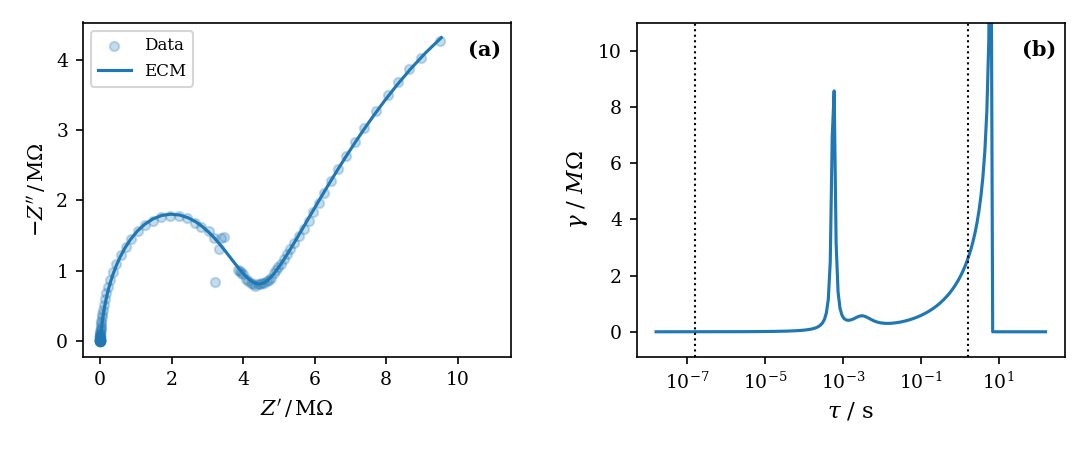

In [382]:
Z_file = '../data/experimental/PDAC_COM3_02109_Contact10_2065C_500C.txt'
Zdf = gt.read_eis_zdata(Z_file)


ecm_param_file = '../data/experimental/EcmParams_PDAC-Ger.pkl'
g_file = '../data/experimental/gamma_PDAC_ECM-Ger.csv'

# def Z_G_HN(w,HFR,Rct,t0hn,nu,beta,Y,t0g):
#     """
#     Impedance of circuit with 1-n parallel RQ circuits in series with a resistor (HFR) and Gerischer element (y, t0)
#     Args:
#         w: frequency (Hz)
#         HFR: high-frequency (ohmic) resistance
#         Rct: resistance of HN element
#         t0hn: time constant of HN element
#         nu: nu parameter for HN element
#         beta: beta parameter of HN element
#         Y: admittance of Gerischer element
#         t0g: time constant of Gerischer element
#     """

#     return gt.Z_HN(w,Rct,t0hn,nu,beta) + HFR + gt.Z_ger(w,Y,t0g)

def Z_varRQ_ger(w,HFR,Y,t0,**RC_params):
    """
    Impedance of circuit with 1-n parallel RQ circuits in series with a resistor (HFR) and Gerischer element (Y, t0)
    Args:
        w: frequency (Hz)
        HFR: high-frequency resistance
        Y: admittance of Gerischer element
        t0: characteristic time constant of Gerischer element
        RC_params: parameters for each parallel RQ circuit. keys: R, Q, n
    """
    num_RC = int(len(RC_params)/3)

    Z_RC = [gt.Z_par(gt.Z_cpe(w,RC_params[f'Q{i}'],RC_params[f'n{i}']), RC_params[f'R{i}']) for i in range(num_RC)]

    return gt.Z_ger(w,Y,t0) + HFR + np.sum(Z_RC,axis=0)

ec_model = Z_varRQ_ger#gt.Z_var_num_RC_noL

fig,axes = plot_ecm_fit(Zdf,ecm_param_file,g_file,ec_model)
# make room for subfig label
axes[0].set_xlim(axes[0].get_xlim()[0],11.5)
# set ylim
axes[1].set_ylim(axes[1].get_ylim()[0],11)

fig.savefig(os.path.join(plotdir,'EcmFit_TCO.jpg'),dpi=500)
fig.savefig(os.path.join(latexdir,'EcmFit_TCO.pdf'),dpi=500)

C:\Users\jdh10\anaconda3\envs\stan\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


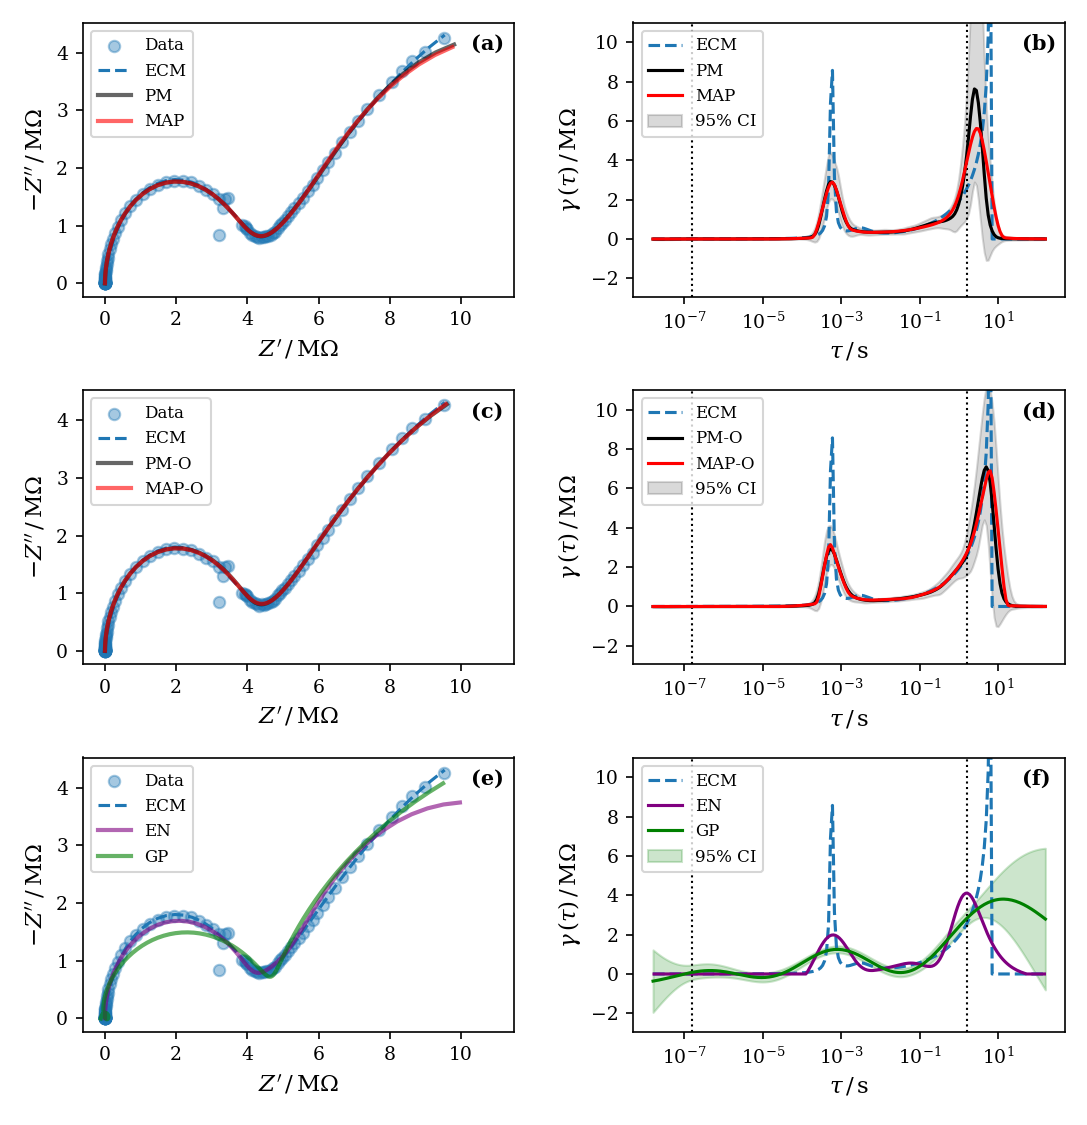

In [383]:
Z_file = '../data/experimental/PDAC_COM3_02109_Contact10_2065C_500C.txt'
Zndf = gt.read_eis_zdata(Z_file)

Zecm_file = '../data/experimental/Z_ECM-ger_PDAC.csv'
g_file = '../data/experimental/gamma_PDAC_ECM-ger.csv'
suffix = '_PDAC'

trunc_tau_plot=False

fig,axes = plt.subplots(3,2,figsize=(7.25,7.5))

for ax in axes[:,0]:
    # plot impedance data
    gt.plot_nyquist(Zndf,ax=ax,label='Data',s=30,alpha=0.4,label_size=label_size)
    # plot ECM fit
    df_ecm = pd.read_csv(Zecm_file)
    gt.plot_nyquist(df_ecm,ax=ax,label='ECM',plot_func='plot',ls='--',label_size=label_size)

# get impedance scale
unit_scale = gt.get_unit_scale(Zndf)
unit_map = {-2:'$\mu$',-1:'m',0:'',1:'k',2:'M',3:'G'}
rev_map = {v:k for k,v in unit_map.items()}
scale_factor = 10**(3*rev_map[unit_scale])

# plot reference DRT from ECM
g_true = pd.read_csv(g_file)
g_true['gamma'] /= scale_factor
if trunc_tau_plot:
    g_true = g_true[(g_true['tau']>= 1/(2*np.pi*Zdf['Freq'].max())) & 
                    (g_true['tau']<= 1/(2*np.pi*Zdf['Freq'].min()))
                   ]
for ax in axes[:,1]:
    ax.plot(g_true['tau'],g_true['gamma'],label='ECM',ls='--')
    # plot measurement boundaries
    ax.axvline(1/(2*np.pi*Zndf['Freq'].min()),ls=':',c='k',lw=1)
    ax.axvline(1/(2*np.pi*Zndf['Freq'].max()),ls=':',c='k',lw=1)

# share axes for Nyquist plots
axes[0,0].get_shared_x_axes().join(axes[0,0],axes[1,0],axes[2,0])
axes[0,0].get_shared_y_axes().join(axes[0,0],axes[1,0],axes[2,0])
# share y axes for all DRT plots
axes[0,1].get_shared_y_axes().join(axes[0,1],axes[1,1],axes[2,1])

# plot DRT and impedance fit for each model
for i,(model_name,info) in enumerate(model_info.items()):
    path = info['path']
    color = info['color']
    
    # plot DRT on appropriate axis
    if model_name in ['PM','MAP']:
        label = model_name
        for i,outliers in enumerate([False,True]):
            # get results filenames
            if outliers:
                add_suff = '_outliers'
                label += '-O'
            else:
                add_suff = ''
            Zout = f'Zout{suffix}{add_suff}.csv'
            Gout = f'Gout{suffix}{add_suff}.csv'
            
            Zres = pd.read_csv(os.path.join(path,Zout))
            Gres = pd.read_csv(os.path.join(path,Gout))
            
            # plot DRT
            if trunc_tau_plot:
                # limit DRT range to data range to avoid large CIs on GP
                Gres = Gres[(Gres['tau']>= 1/(2*np.pi*Zdf['Freq'].max())) & (Gres['tau']<= 1/(2*np.pi*Zdf['Freq'].min()))]
            scale_cols = ['gamma','gamma_lo','gamma_hi','sigma_gamma']
            for col in scale_cols:
                try:
                    Gres[col] /= scale_factor
                except KeyError:
                    pass
            if model_name=='PM':
                axes[i,1].plot(Gres['tau'],Gres['gamma'],label=label,c=color)
                axes[i,1].fill_between(Gres['tau'],Gres['gamma_lo'],Gres['gamma_hi'],alpha=0.15,label='95% CI',
                                       color=color,lw=1)
            elif model_name=='MAP':
                axes[i,1].plot(Gres['tau'],Gres['gamma'],label=label,c=color,ls='-',alpha=1)
                
            # plot fitted impedance
            if model_name=='PM':
                # parse complex numbers
                real_cols = ['freq','Zreal','Zimag']
                for col in real_cols:
                    Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x))
                    Zres[col] = np.real(Zres[col])
                imag_cols = ['Zlo','Zhi']
                for col in imag_cols:
                    Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x)) 
            gt.plot_nyquist(Zres,ax=axes[i,0],plot_func='plot',label=label,c=color,lw=2,alpha=0.6,
                            label_size=label_size)
                
    else:
        Zout = f'Zout{suffix}.csv'
        Gout = f'Gout{suffix}.csv'

        Zres = pd.read_csv(os.path.join(path,Zout))
        Gres = pd.read_csv(os.path.join(path,Gout))

        if trunc_tau_plot:
            # limit DRT range to data range to avoid large CIs on GP
            Gres = Gres[(Gres['tau']>= 1/(2*np.pi*Zdf['Freq'].max())) & (Gres['tau']<= 1/(2*np.pi*Zdf['Freq'].min()))]
        scale_cols = ['gamma','gamma_lo','gamma_hi','sigma_gamma']
        for col in scale_cols:
            try:
                Gres[col] /= scale_factor
            except KeyError:
                pass
        if model_name=='GP':
            axes[2,1].plot(Gres['tau'],Gres['gamma'],c=color,label='GP')
            axes[2,1].fill_between(Gres['tau'],Gres['gamma']-2*Gres['sigma_gamma'],Gres['gamma']+2*Gres['sigma_gamma'],
                                alpha=0.2,color=color,label='95% CI',lw=1)
        else:
            axes[2,1].plot(Gres['tau'],Gres['gamma'],c=color,label=model_name)

     
        gt.plot_nyquist(Zres,ax=axes[2,0],plot_func='plot',label=model_name,c=color,lw=2,alpha=0.6,label_size=label_size)

for ax in axes[:,1]:
    ax.set_xscale('log')
    ax.legend(fontsize=tick_size-1,loc='upper left')
    ax.set_xlabel(r'$\tau \, / \, $s',size=label_size)
    ax.set_ylabel(fr'$\gamma\,(\tau) \, / \, \mathrm{{{unit_scale}}}\Omega$',size=label_size)

for ax in axes.ravel():
    ax.tick_params(labelsize=tick_size)

# reorder legend entries for Nyquist plots 
for ax in axes[:,0]:
    h,l = ax.get_legend_handles_labels()
    srt_idx = [-1,0,1,2]
    ax.legend(handles=[h[idx] for idx in srt_idx],labels=[l[idx] for idx in srt_idx])
    

# subfigure labels
for n,ax in enumerate(axes.ravel()):
    let = chr(n+97)
    ax.text(0.9,0.9,f'({let})',transform=ax.transAxes,fontweight='bold')
    
# make room for subfig labels
axes[0,0].set_xlim(axes[0,0].get_xlim()[0],11.5)
    

for ax in axes[:,1]:
    ax.set_ylim(ax.get_ylim()[0],11)
    
fig.tight_layout()

fig.savefig(os.path.join(plotdir,'DrtComparison_TCO.jpg'),dpi=500)
fig.savefig(os.path.join(latexdir,'DrtComparison_TCO.pdf'),dpi=500)

C:\Users\jdh10\anaconda3\envs\stan\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


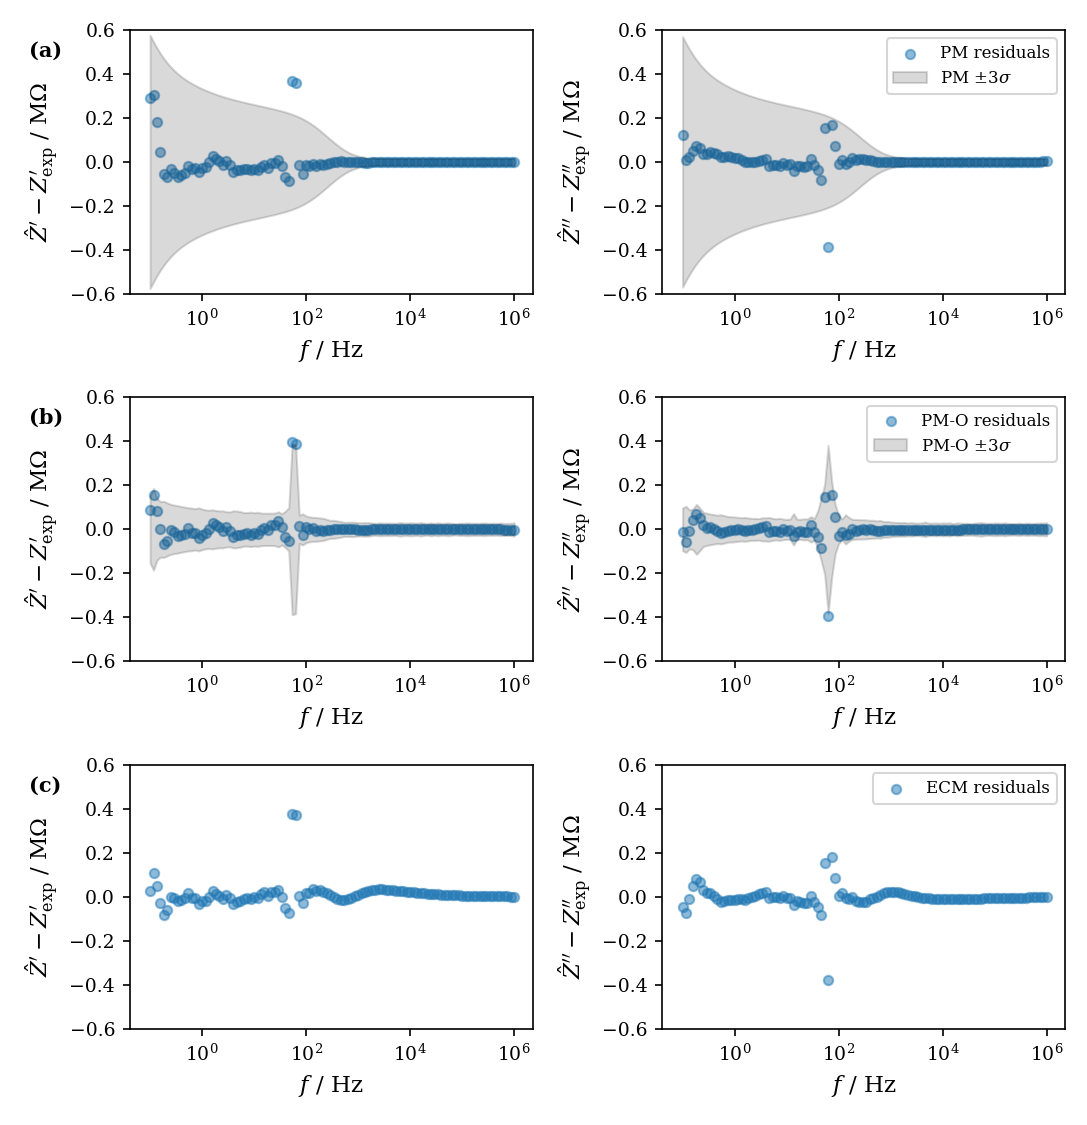

In [384]:
# plot residuals for ECMs and PM
fig,axes = plt.subplots(3,2,figsize=(7.25,7.5))

# axes[0,0].get_shared_y_axes().join(ax for ax in axes.ravel())

Z_file = '../data/experimental/PDAC_COM3_02109_Contact10_2065C_500C.txt'
Zndf = gt.read_eis_zdata(Z_file)
# scale to M Ohms
Zndf['Zreal'] /= 1e6
Zndf['Zimag'] /= 1e6

Zres_files = ['bayes_results/Zout_PDAC.csv',
             'bayes_results/Zout_PDAC_outliers.csv',
#              '../data/experimental/Z_ECM_PDAC.csv',
             '../data/experimental/Z_ECM-ger_PDAC.csv']
model_names = ['PM','PM-O','ECM']
scat_kw = {'s':20,'alpha':0.5}

for axrow, model_name,Zres_file in zip(axes,model_names,Zres_files):
    Zres = pd.read_csv(Zres_file)
    if model_name[:2]=='PM':
        # parse complex numbers
        real_cols = ['freq','Zreal','Zimag']
        for col in real_cols:
            Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x))
            Zres[col] = np.real(Zres[col])
        imag_cols = ['Zlo','Zhi']
        for col in imag_cols:
            Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x)) 
    # scale to M Ohms
    Zres['Zreal'] /= 1e6
    Zres['Zimag'] /= 1e6
    axrow[0].scatter(Zndf['Freq'],Zres['Zreal']-Zndf['Zreal'],
                     label=fr'{model_name} residuals',**scat_kw
                    )
    axrow[1].scatter(Zndf['Freq'],Zres['Zimag']-Zndf['Zimag'],
                     label=fr'{model_name} residuals',**scat_kw
                    )
    
# show error scales from  fits
obj_files = ['bayes_results/obj_PDAC.pkl','bayes_results/obj_PDAC_outliers.pkl']
for axrow, obj_file in zip(axes,obj_files):
    if obj_file.find('outliers') > 0:
        model_name = 'PM-O'
    else:
        model_name = 'PM'
    dr_mcmc = load_pickle(obj_file)
    sigma_re,sigma_im = dr_mcmc.predict_err_scale(dr_mcmc.f_train)
    axrow[0].fill_between(dr_mcmc.f_train,-3e-6*sigma_re,3e-6*sigma_re,alpha=0.15,color='k',
                          label=f'{model_name} $\pm 3\sigma^{{\prime}}$'
                         )
    axrow[1].fill_between(dr_mcmc.f_train,-3e-6*sigma_im,3e-6*sigma_im,alpha=0.15,color='k',
                         label=f'{model_name} $\pm 3\sigma$'
                         )
    
for ax in axes.ravel():
    ax.set_xscale('log')
    ax.set_xlabel('$f$ / Hz')
    ax.set_ylim(-0.6,0.6)
for n,ax in enumerate(axes[:,0]):
    ax.set_ylabel('$\hat{Z}^{\prime}-Z^{\prime}_{\mathrm{exp}}$ / M$\Omega$')
#     ax.legend()
    # subfig labels
    let = chr(n+97)
    ax.text(-0.25,0.9,f'({let})',transform=ax.transAxes,fontweight='bold')
    
for ax in axes[:,1]:
    ax.set_ylabel('$\hat{Z}^{\prime\prime}-Z^{\prime\prime}_{\mathrm{exp}}$ / M$\Omega$')
    ax.legend()

fig.tight_layout()
fig.savefig(os.path.join(plotdir,'Residuals_TCO.jpg'),dpi=500)
fig.savefig(os.path.join(latexdir,'Residuals_TCO.pdf'),dpi=500)

<IPython.core.display.Javascript object>


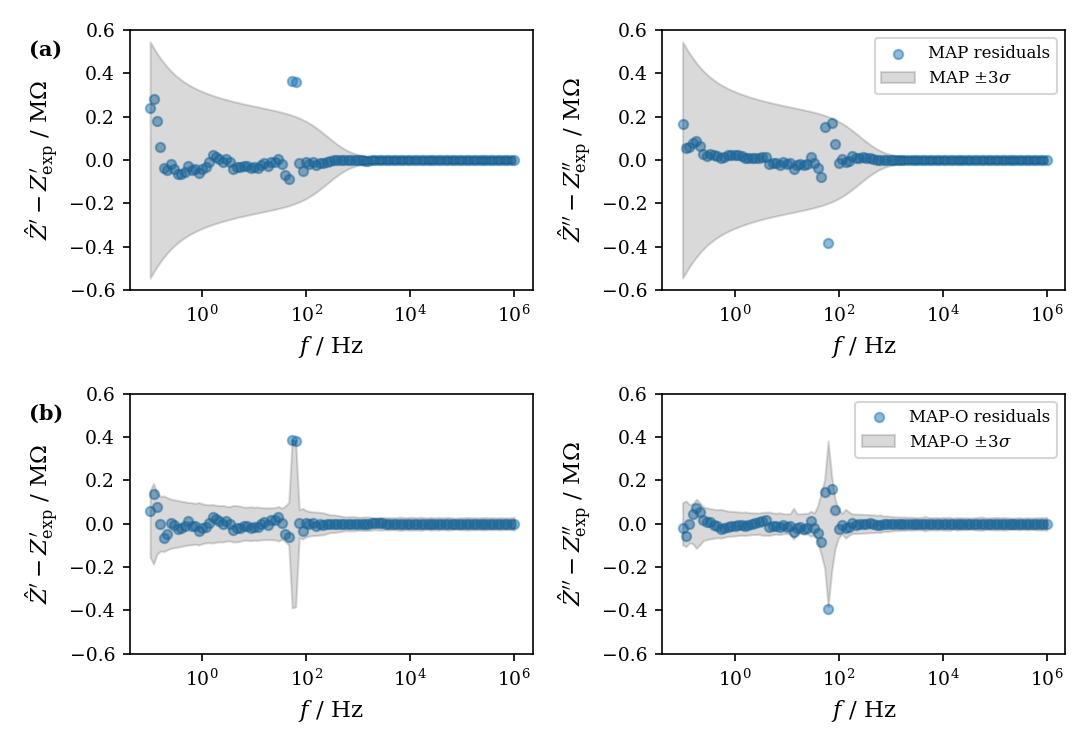

In [224]:
"Residuals for MAP (supplementary)"
# plot residuals for ECMs and MAP
fig,axes = plt.subplots(2,2,figsize=(7.25,5))

# axes[0,0].get_shared_y_axes().join(ax for ax in axes.ravel())

Z_file = '../data/experimental/PDAC_COM3_02109_Contact10_2065C_500C.txt'
Zndf = gt.read_eis_zdata(Z_file)
# scale to M Ohms
Zndf['Zreal'] /= 1e6
Zndf['Zimag'] /= 1e6

Zres_files = ['map_results/Zout_PDAC.csv',
             'map_results/Zout_PDAC_outliers.csv']
model_names = ['MAP','MAP-O']
scat_kw = {'s':20,'alpha':0.5}

for axrow, model_name,Zres_file in zip(axes,model_names,Zres_files):
    Zres = pd.read_csv(Zres_file)
    if model_name[:2]=='PM':
        # parse complex numbers
        real_cols = ['freq','Zreal','Zimag']
        for col in real_cols:
            Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x))
            Zres[col] = np.real(Zres[col])
        imag_cols = ['Zlo','Zhi']
        for col in imag_cols:
            Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x)) 
    # scale to M Ohms
    Zres['Zreal'] /= 1e6
    Zres['Zimag'] /= 1e6
    axrow[0].scatter(Zndf['Freq'],Zres['Zreal']-Zndf['Zreal'],
                     label=fr'{model_name} residuals',**scat_kw
                    )
    axrow[1].scatter(Zndf['Freq'],Zres['Zimag']-Zndf['Zimag'],
                     label=fr'{model_name} residuals',**scat_kw
                    )
    
# show error scales from fits
obj_files = ['map_results/obj_PDAC.pkl','bayes_results/obj_PDAC_outliers.pkl']
for axrow, obj_file in zip(axes,obj_files):
    if obj_file.find('outliers') > 0:
        model_name = 'MAP-O'
    else:
        model_name = 'MAP'
    dr_mcmc = load_pickle(obj_file)
    sigma_re,sigma_im = dr_mcmc.predict_err_scale(dr_mcmc.f_train)
    axrow[0].fill_between(dr_mcmc.f_train,-3e-6*sigma_re,3e-6*sigma_re,alpha=0.15,color='k',
                          label=f'{model_name} $\pm 3\sigma^{{\prime}}$'
                         )
    axrow[1].fill_between(dr_mcmc.f_train,-3e-6*sigma_im,3e-6*sigma_im,alpha=0.15,color='k',
                         label=f'{model_name} $\pm 3\sigma$'
                         )
    
for ax in axes.ravel():
    ax.set_xscale('log')
    ax.set_xlabel('$f$ / Hz')
    ax.set_ylim(-0.6,0.6)
for n,ax in enumerate(axes[:,0]):
    ax.set_ylabel('$\hat{Z}^{\prime}-Z^{\prime}_{\mathrm{exp}}$ / M$\Omega$')
#     ax.legend()
    # subfig labels
    let = chr(n+97)
    ax.text(-0.25,0.9,f'({let})',transform=ax.transAxes,fontweight='bold')
    
for ax in axes[:,1]:
    ax.set_ylabel('$\hat{Z}^{\prime\prime}-Z^{\prime\prime}_{\mathrm{exp}}$ / M$\Omega$')
    ax.legend()

fig.tight_layout()
fig.savefig(os.path.join(plotdir,'MapResiduals_TCO.jpg'),dpi=500)
fig.savefig(os.path.join(latexdir,'MapResiduals_TCO.pdf'),dpi=500)

In [ ]:
"DRT-informed ECM"

fig,axes = plt.subplots(2,2,figsize=(7.25,5))


# Supplementary figures
## Influence of sampling scheme

C:\Users\jdh10\anaconda3\envs\stan\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


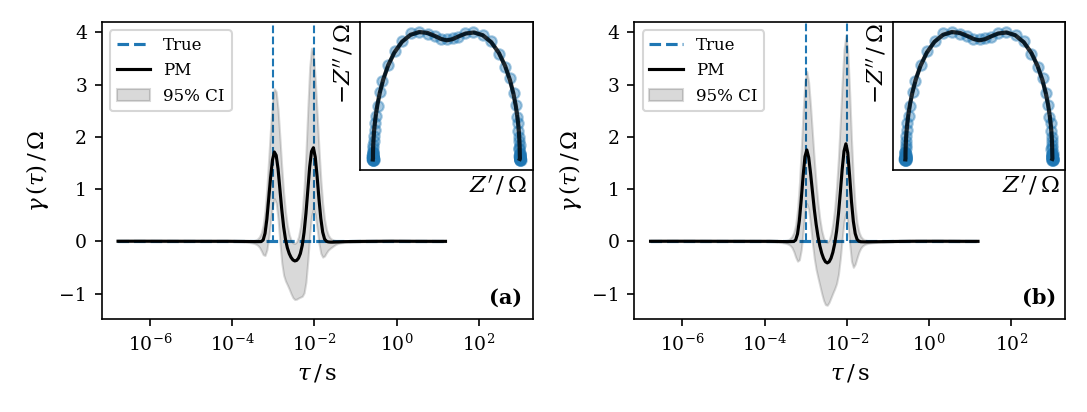

In [377]:
fig, axes = plt.subplots(1,2,figsize=(7.25,2.75))

# load impedance data
circ = '2RC'
err_model = 'uniform'
noise_level = 0.25
Z_file = os.path.join(data_path,'simulated',f'Z_{circ}_noiseless.csv')
Zn_file = os.path.join(data_path,'simulated',f'Z_{circ}_{err_model}_{noise_level}.csv')
Zdf = pd.read_csv(Z_file)
Zndf = pd.read_csv(Zn_file)

# share y axes for all DRT plots
axes[0].get_shared_y_axes().join(axes[0],axes[1])

# get results filenames
fname = os.path.split(Zn_file)[1]
suffix = fname[1:-4]
Zout = f'Zout{suffix}.csv'
Gout = f'Gout{suffix}.csv'

Zout_fs = f'Zout{suffix}_4x1000.csv'
Gout_fs = f'Gout{suffix}_4x1000.csv'


# plot DRT and impedance fit for each model
path = model_info['PM']['path']
color = model_info['PM']['color']
Zres_ss = pd.read_csv(os.path.join(path,Zout))
Gres_ss = pd.read_csv(os.path.join(path,Gout))
Zres_fs = pd.read_csv(os.path.join(path,Zout_fs))
Gres_fs = pd.read_csv(os.path.join(path,Gout_fs))

for Zres,Gres,ax in zip([Zres_ss,Zres_fs],[Gres_ss,Gres_fs],axes):
    # limit DRT range to data range
    tmin = 1/(2*np.pi*Zdf['Freq'].max())
    tmax = 1/(2*np.pi*Zdf['Freq'].min())
    Gres = Gres[(Gres['tau']>= tmin) & (Gres['tau']<= tmax)]

    # plot DRT
    ax.plot(Gres['tau'],Gres['gamma'],label='PM',c=color)
    ax.fill_between(Gres['tau'],Gres['gamma_lo'],Gres['gamma_hi'],alpha=0.15,label='95% CI',
                           color=color,lw=1)

    # plot fitted impedance
    # parse complex numbers
    real_cols = ['freq','Zreal','Zimag']
    for col in real_cols:
        Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x))
        Zres[col] = np.real(Zres[col])
    imag_cols = ['Zlo','Zhi']
    for col in imag_cols:
        Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x))
    axi = ax.inset_axes([0.6,0.5,0.4,0.5])
    gt.plot_nyquist(Zdf,ax=axi,plot_func='plot',ls='--',label_size=tick_size)
    gt.plot_nyquist(Zndf,ax=axi,s=25,alpha=0.4,label_size=tick_size)
    gt.plot_nyquist(Zres,ax=axi,plot_func='plot',label=model_name,c=color,lw=2,alpha=0.8,label_size=label_size)
    
    # formatting
    ax.set_xscale('log')
    ax.set_xlabel(r'$\tau \, / \, $s',size=label_size)
    ax.set_ylabel(r'$\gamma\,(\tau) \, / \, \Omega$',size=label_size)
    ax.set_xlim(ax.get_xlim()[0],2e3)

    axi.set_xticks([])
    axi.set_yticks([])
    axi.get_legend().remove()
    axi.xaxis.set_label_coords(0.8,-0.025)
    axi.yaxis.set_label_coords(-0.025,0.72)
    
    # plot true DRT
    ax.axhline(0,ls='--',label='True',zorder=-10,xmin=ax.transLimits.transform((np.log10(tmin),0))[0],
              xmax=ax.transLimits.transform((np.log10(tmax),0))[0])
    ax.axvline(1e-3,ls='--',ymin=ax.transLimits.transform((1,0))[1],zorder=-10,lw=1)
    ax.axvline(1e-2,ls='--',ymin=ax.transLimits.transform((1,0))[1],zorder=-10,lw=1)
    
    # reorder legend
    h,l = ax.get_legend_handles_labels()
    srt_idx = [1,0,2]
    ax.legend(handles=[h[i] for i in srt_idx],labels=[l[i] for i in srt_idx],fontsize=tick_size-1,loc='upper left')

# subfigure labels
for n,ax in enumerate(axes):
    let = chr(n+97)
    ax.text(0.9,0.05,f'({let})',transform=ax.transAxes,fontweight='bold')

fig.tight_layout()
fig.savefig(os.path.join(plotdir,'SamplingComparison_2RC.jpg'),dpi=500)
fig.savefig(os.path.join(latexdir,'SamplingComparison_2RC.pdf'),dpi=500)

## Initial solution method

C:\Users\jdh10\anaconda3\envs\stan\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


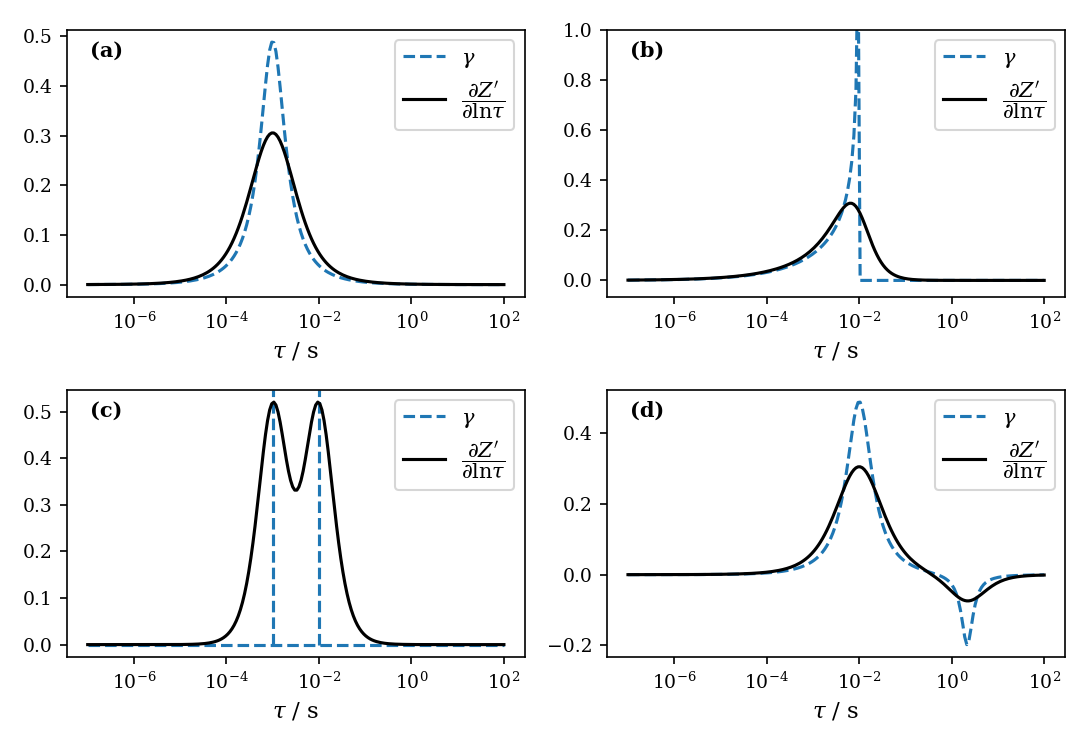

C:\Users\jdh10\anaconda3\envs\stan\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [369]:
"demonstrate dZ/dlnt vs gamma"

fig,axes = plt.subplots(2,2,figsize=(7.25,5))

# ZARC
circ = 'ZARC'
g_file = os.path.join(data_path,'simulated',f'gamma_{circ}.csv')
g_true = pd.read_csv(g_file)
axes[0,0].plot(g_true['tau'],g_true['gamma'],label='$\gamma$',ls='--')
R = 1
Q = 1e-3**0.8
phi = 0.8
w = 1/g_true['tau'].values
dZ = np.real(R**2*Q*phi*(1j*w)**phi/(1+R*Q*(1j*w)**phi)**2)
axes[0,0].plot(g_true['tau'],dZ,label=r'$\dfrac{\partial Z^\prime}{\partial \ln{\tau}}$',c='k')

# Gerischer
circ = 'Gerischer'
g_file = os.path.join(data_path,'simulated',f'gamma_{circ}.csv')
g_true = pd.read_csv(g_file)
axes[0,1].plot(g_true['tau'],g_true['gamma'],label='$\gamma$',ls='--')
R = 1
t0 = 1e-2
w = 1/g_true['tau'].values
dZ = 0.5*R*1j*t0*w/(1+1j*w*t0)**1.5
axes[0,1].plot(g_true['tau'],dZ,label=r'$\dfrac{\partial Z^\prime}{\partial \ln{\tau}}$',c='k')
axes[0,1].set_ylim(axes[0,1].get_ylim()[0],1)

# 2 RC
circ = '2RC'
R1 = 1
Q1 = 1e-3
phi1 = 1
R2 = 1
Q2 = 1e-2
phi2 = 1
w = 1/g_true['tau'].values
dZ1 = np.real(R1**2*Q1*phi1*(1j*w)**phi1/(1+R1*Q1*(1j*w)**phi1)**2)
dZ2 = np.real(R2**2*Q2*phi2*(1j*w)**phi2/(1+R2*Q2*(1j*w)**phi2)**2)
axes[1,0].plot(g_true['tau'],dZ1+dZ2,label=r'$\dfrac{\partial Z^\prime}{\partial \ln{\tau}}$',c='k')
# plto true DRT - must be done after all other plotting and axis scaling
axes[1,0].set_xscale('log')
axes[1,0].axhline(0,ls='--',label='$\gamma$',xmin=axes[1,0].transLimits.transform((-7,0))[0],
                 xmax=axes[1,0].transLimits.transform((2,0))[0],zorder=-10)
axes[1,0].axvline(1e-3,ls='--',ymin=axes[1,0].transLimits.transform((1,0))[1],zorder=-10)
axes[1,0].axvline(1e-2,ls='--',ymin=axes[1,0].transLimits.transform((1,0))[1],zorder=-10)

# ZARC w/inductive curl
circ = 'ZARC-RL'
g_file = os.path.join(data_path,'simulated',f'gamma_{circ}.csv')
g_true = pd.read_csv(g_file)
axes[1,1].plot(g_true['tau'],g_true['gamma'],label='$\gamma$',ls='--')
R1 = 1
Q1 = 1e-2**0.8
phi1 = 0.8
R2 = -0.2
Q2 = -10
phi2 = 0.9
w = 1/g_true['tau'].values
dZ1 = np.real(R1**2*Q1*phi1*(1j*w)**phi1/(1+R1*Q1*(1j*w)**phi1)**2)
dZ2 = np.real(R2**2*Q2*phi2*(1j*w)**phi2/(1+R2*Q2*(1j*w)**phi2)**2)
axes[1,1].plot(g_true['tau'],dZ1+dZ2,label=r'$\dfrac{\partial Z^\prime}{\partial \ln{\tau}}$',c='k')


for n,ax in enumerate(axes.ravel()):
    ax.set_xscale('log')
    ax.legend(fontsize=10)
    ax.set_xlabel(r'$\tau \ / \ $s')
    let = chr(n+97)
    ax.text(0.05,0.9,f'({let})',transform=ax.transAxes,fontweight='bold')
    
# reverse legend order for 2RC
h,l = axes[1,0].get_legend_handles_labels()
axes[1,0].legend(handles=h[::-1],labels=l[::-1],fontsize=10)
    
fig.tight_layout()
fig.savefig(os.path.join(plotdir,'dZ_vs_gamma.jpg'),dpi=500)
fig.savefig(os.path.join(latexdir,'dZ_vs_gamma.pdf'),dpi=500)

In [5]:
# initialize DRT for hyper-ridge fits
dri = drt.DRT()

<IPython.core.display.Javascript object>


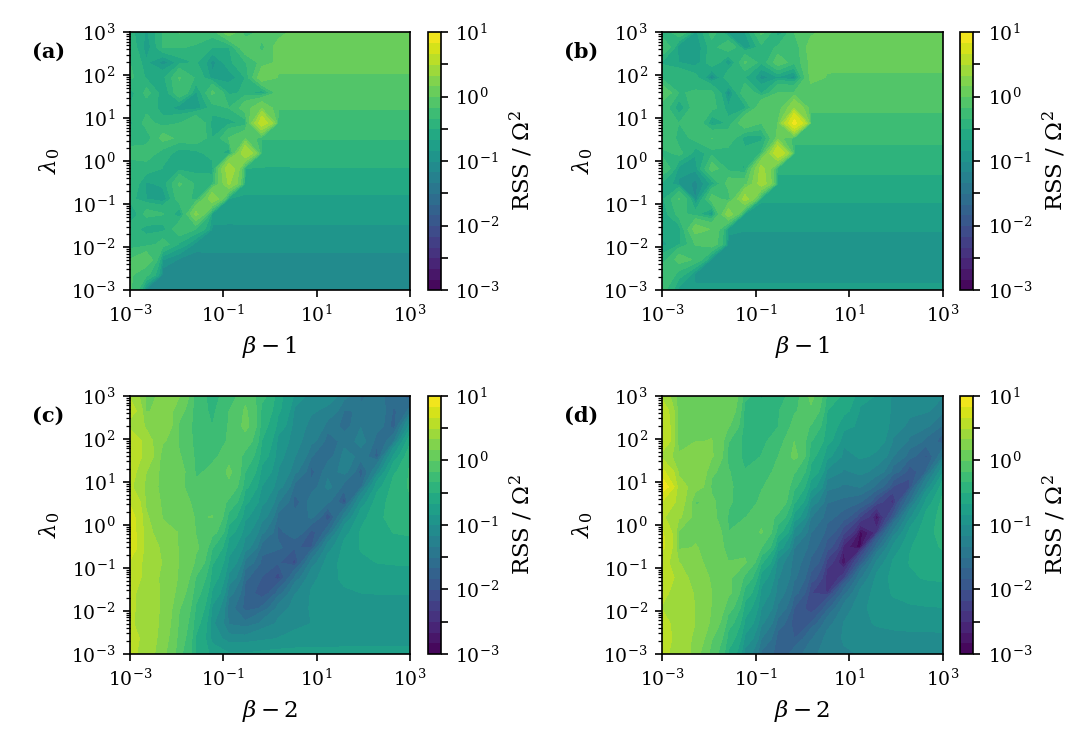

In [75]:
circ = 'ZARC'
err_model = 'Macdonald'
noise_level = 1.0

# Z_file = os.path.join(data_path,'simulated',f'Z_{circ}_noiseless.csv')
Zn_file = os.path.join(data_path,'simulated',f'Z_{circ}_{err_model}_{noise_level}.csv')

# load impedance data
# Zdf = pd.read_csv(Z_file)
Zndf = pd.read_csv(Zn_file)
Zc = Zndf['Zreal'].values + 1j*Zndf['Zimag'].values

# load true DRT
g_file = os.path.join(data_path,'simulated',f'gamma_{circ}.csv')
g_true = pd.read_csv(g_file)
g_true = g_true[(g_true['tau']>= 1/(2*np.pi*Zndf['Freq'].max())) & (g_true['tau']<= 1/(2*np.pi*Zndf['Freq'].min()))]

# create hyperparam grid 
beta_plus = np.logspace(-3,3,18)
lams = np.logspace(-3,3,18)
bb,ll = np.meshgrid(beta_plus,lams)
xbetas = []
ylams = []

# set kwargs for each approach
kw_list = [dict(reg_ord=2,dZ=False,hyper_penalty='cholesky',nonneg=True),
           dict(reg_ord=2,dZ=False,hyper_penalty='cholesky',nonneg=False),
           dict(reg_ord=2,dZ=False,hyper_penalty='integral',nonneg=False),
           dict(reg_ord=2,dZ=True,hyper_penalty='integral',nonneg=False),
          ]

# drt_rss = []
# for kw in kw_list[3:]:
#     print(kw['hyper_penalty'])
#     rss = np.zeros_like(ll)
#     if kw['hyper_penalty']=='cholesky':
#         beta_offset = 1
#     elif kw['hyper_penalty']=='integral':
#         beta_offset = 2
#     for (i,j),lam in np.ndenumerate(ll):
#             # fit
#             beta = bb[i,j] + beta_offset
#             print(beta,lam)
#             dri.ridge_fit(Zndf['Freq'].values,Zc,beta=beta,lambda_0=lam,**kw)

#             # get rss
#             pred_drt = dri.drt(g_true['tau'])
#             rss[i,j] = np.sum((pred_drt-g_true['gamma'])**2)
#     drt_rss.append(rss)
        

fig,axes = plt.subplots(2,2,figsize=(7.25,5))

for ax, rss, kw in zip(axes.ravel(),drt_rss,kw_list):
    if kw['hyper_penalty']=='cholesky':
        beta_offset = 1
    elif kw['hyper_penalty']=='integral':
        beta_offset = 2
    p = ax.contourf(bb,ll,rss,locator=ticker.LogLocator(),levels=np.logspace(-3.,1,25))
                    #norm=colors.LogNorm(vmin=rss.min(),vmax=rss.max()))#,vmin=-7.3,vmax=1.7)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(fr'$\beta-{beta_offset}$')
    ax.set_ylabel(r'$\lambda_0$')
    plt.colorbar(p,ax=ax,label='RSS / $\Omega^2$')
    
for n,ax in enumerate(axes.ravel()):
    let = chr(n+97)
    ax.text(-0.35,0.9,f'({let})',transform=ax.transAxes,fontweight='bold')

fig.tight_layout()
fig.savefig(os.path.join(plotdir,'Init_ZARC_paramgrid.jpg'),dpi=500)
fig.savefig(os.path.join(latexdir,'Init_ZARC_paramgrid.pdf'),dpi=500)

In [16]:
best_params

[{'beta': 1.005080218046913, 'lambda_0': 0.0011450475699382812},
 {'beta': 1.005080218046913, 'lambda_0': 100.0},
 {'beta': 5.383855153428237, 'lambda_0': 0.15013107289081742},
 {'beta': 19.190722018585745, 'lambda_0': 0.3383855153428237}]

In [72]:
best_params

[{'beta': 1.005080218046913, 'lambda_0': 0.001},
 {'beta': 1.0114504756993827, 'lambda_0': 87.33261623828437},
 {'beta': 3.501310728908174, 'lambda_0': 0.05817091329374361},
 {'beta': 19.190722018585745, 'lambda_0': 0.2955209235202888}]

0.06895288371603064
0.07127712897036693
0.007696291608497078
0.0010079176353263249


<IPython.core.display.Javascript object>


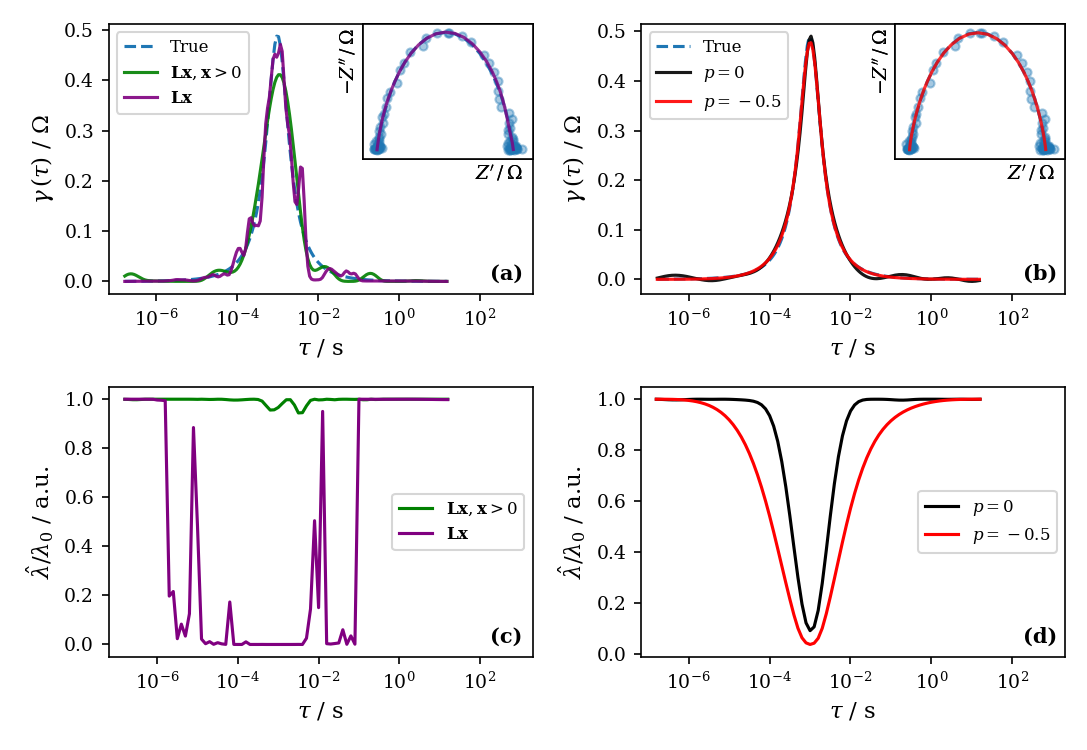

C:\Users\jdh10\anaconda3\envs\stan\lib\site-packages\ipykernel_launcher.py:72: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
C:\Users\jdh10\anaconda3\envs\stan\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
../bayes-drt\drt.py:327: UserWarning: Hyperparametric solution did not converge within 20 iterations
  iter += 1
C:\Users\jdh10\anaconda3\envs\stan\lib\site-packages\ipykernel_launcher.py:72: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
C:\Users\jdh10\anaconda3\envs\stan\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


In [129]:
best_params = []
for rss in drt_rss:
    bp = {}
    print(np.min(rss))
    bp['beta'] = bb.ravel()[np.argmin(rss)]
    bp['lambda_0'] = ll.ravel()[np.argmin(rss)]
    best_params.append(bp)

fig,axes = plt.subplots(2,2,figsize=(7.25,5))

circ = 'ZARC'
err_model = 'Macdonald'
noise_level = 1.0

Z_file = os.path.join(data_path,'simulated',f'Z_{circ}_noiseless.csv')
Zn_file = os.path.join(data_path,'simulated',f'Z_{circ}_{err_model}_{noise_level}.csv')

# load impedance data
Zdf = pd.read_csv(Z_file)
Zndf = pd.read_csv(Zn_file)
Zc = Zndf['Zreal'].values + 1j*Zndf['Zimag'].values

# plot true DRT
g_file = os.path.join(data_path,'simulated',f'gamma_{circ}.csv')
g_true = pd.read_csv(g_file)
g_true = g_true[(g_true['tau']>= 1/(2*np.pi*Zdf['Freq'].max())) & (g_true['tau']<= 1/(2*np.pi*Zdf['Freq'].min()))]
for ax in axes[0]:
    ax.plot(g_true['tau'],g_true['gamma'],label='True',ls='--')
    
colors = ['g','purple','k','r']
labels = ['$\mathbf{Lx},\mathbf{x}>0$',
          '$\mathbf{Lx}$',
          '$p=0$',
          '$p=-0.5$'
#           r'$\mathbf{x}^{\mathrm{T}} \Lambda \mathbf{M} \Lambda \mathbf{x}$',
#           r'$\mathbf{x}^{\mathrm{T}} \Lambda \mathbf{DMD} \Lambda \mathbf{x}$'
         ]

for kw,bp,color,label in zip(kw_list,best_params,colors,labels):
    kw = kw.copy()
    if kw['hyper_penalty']=='cholesky':
        beta_offset = 1
        i = 0
    elif kw['hyper_penalty']=='integral':
        beta_offset = 2
        i = 2
    bp['beta'] += beta_offset
    kw.update(bp)
    ax1 = axes[0,int(i/2)]
    ax2 = axes[1,int(i/2)]
    
    # plot DRT
    dri.ridge_fit(Zndf['Freq'].values,Zc,**kw)
    ax1.plot(g_true['tau'],dri.drt(g_true['tau']),c=color,label=label,alpha=0.9)
    
    # plot lambda
    ax2.plot(dri.tau,dri.lambda_vectors_[2][2:]/bp['lambda_0'],c=color,label=label)
    
    # plot impedance fit
    axi = ax1.inset_axes([0.6,0.5,0.4,0.5])
    gt.plot_nyquist(Zdf,ax=axi,label='True',plot_func='plot',ls='--',label_size=tick_size)
    gt.plot_nyquist(Zndf,ax=axi,label='Data',s=15,alpha=0.4,label_size=tick_size)
    Z_pred = dri.predict(Zdf['Freq'].values)
    df_pred = gt.construct_eis_df(Zdf['Freq'],Z_pred)
    gt.plot_nyquist(df_pred,ax=axi,plot_func='plot',c=color,label_size=tick_size,alpha=0.8)
    
    # formatting
    ax1.set_xscale('log')
    ax1.legend(loc='upper left')
    ax1.set_xlabel(r'$\tau \ / \ $s')
    ax1.set_ylabel(r'$\gamma\,(\tau) \ / \ \Omega$')
    ax1.set_xlim(ax.get_xlim()[0],2e3)
    
    ax2.set_xscale('log')
    ax2.legend(loc='center right')
    ax2.set_xlabel(r'$\tau \ / \ $s')
    ax2.set_ylabel(r'$\hat{\lambda}/\lambda_0$ / a.u.')
    ax2.set_xlim(ax.get_xlim()[0],2e3)
    
    axi.set_xticks([])
    axi.set_yticks([])
    axi.get_legend().remove()
    axi.xaxis.set_label_coords(0.8,-0.04)
    axi.yaxis.set_label_coords(-0.025,0.72)
    
for n,ax in enumerate(axes.ravel()):
    let = chr(n+97)
    ax.text(0.9,0.05,f'({let})',transform=ax.transAxes,fontweight='bold')

fig.tight_layout()
fig.savefig(os.path.join(plotdir,'Init_ZARC_DRT.jpg'),dpi=500)
fig.savefig(os.path.join(latexdir,'Init_ZARC_DRT.pdf'),dpi=500)

In [ ]:
dri.lambda_vectors_

C:\Users\jdh10\anaconda3\envs\stan\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


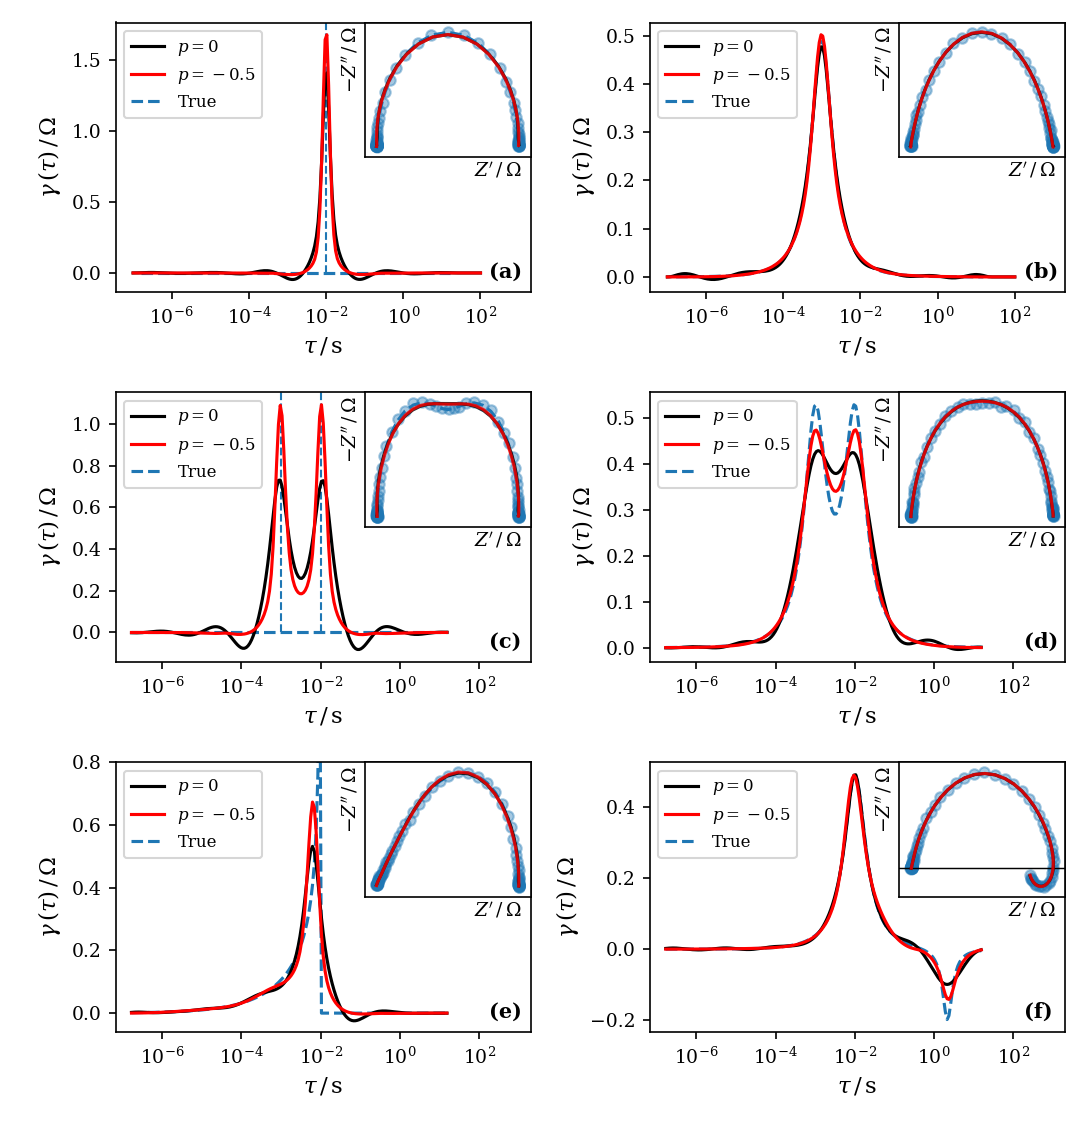

../bayes-drt\drt.py:327: UserWarning: Hyperparametric solution did not converge within 20 iterations
  iter += 1
../bayes-drt\drt.py:327: UserWarning: Hyperparametric solution did not converge within 20 iterations
  iter += 1
../bayes-drt\drt.py:327: UserWarning: Hyperparametric solution did not converge within 20 iterations
  iter += 1
../bayes-drt\drt.py:327: UserWarning: Hyperparametric solution did not converge within 20 iterations
  iter += 1


In [372]:
"6 basic simulated spectra"
fig,axes = plt.subplots(3,2,figsize=(7.25,7.5))

circuits = ['RC','ZARC','2RC','2ZARC','Gerischer','ZARC-RL']
err_model = 'uniform'
noise_level = 0.25

for circ,ax in zip(circuits,axes.ravel()):
    Z_file = os.path.join(data_path,'simulated',f'Z_{circ}_noiseless.csv')
    Zn_file = os.path.join(data_path,'simulated',f'Z_{circ}_{err_model}_{noise_level}.csv')
    
    # plot impedance data on inset
    axi = ax.inset_axes([0.6,0.5,0.4,0.5])
    Zdf = pd.read_csv(Z_file)
    Zndf = pd.read_csv(Zn_file)
    gt.plot_nyquist(Zdf,ax=axi,label='True',plot_func='plot',ls='--',label_size=tick_size)
    gt.plot_nyquist(Zndf,ax=axi,label='Data',s=25,alpha=0.4,label_size=tick_size)
    if circ=='ZARC-RL':
        # indicate zero
        axi.axhline(0,lw=0.7,c='k')
        
    # hyper ridge fit (p=0)
    Zc = Zndf['Zreal'].values + 1j*Zndf['Zimag'].values
    dri.ridge_fit(Zndf['Freq'].values,Zc,beta=2.5,lambda_0=1e-2,reg_ord=2,dZ=False)
    
    # plot estimated DRT
    ax.plot(g_true['tau'],dri.drt(g_true['tau']),label='$p=0$',c='k')

    # plot impedance fit
    Z_pred = dri.predict(dri.f_train)
    Zres = gt.construct_eis_df(dri.f_train,Z_pred)
    gt.plot_nyquist(Zres,ax=axi,plot_func='plot',c='k',label_size=tick_size,alpha=0.8)
    
    # hyper ridge fit (p=-0.5)
    Zc = Zndf['Zreal'].values + 1j*Zndf['Zimag'].values
    dri.ridge_fit(Zndf['Freq'].values,Zc,beta=2.5,lambda_0=1e-2,reg_ord=2,dZ=True)
    
    # plot estimated DRT
    ax.plot(g_true['tau'],dri.drt(g_true['tau']),label='$p=-0.5$',c='r')

    # plot impedance fit
    Z_pred = dri.predict(dri.f_train)
    Zres = gt.construct_eis_df(dri.f_train,Z_pred)
    gt.plot_nyquist(Zres,ax=axi,plot_func='plot',c='r',label_size=tick_size,alpha=0.8)
            
    ax.set_xscale('log')
    ax.set_xlabel(r'$\tau \, / \, $s')
    ax.set_ylabel(r'$\gamma\,(\tau) \, / \, \Omega$')
    ax.set_xlim(ax.get_xlim()[0],2e3)
    
    axi.set_xticks([])
    axi.set_yticks([])
    axi.get_legend().remove()
    axi.xaxis.set_label_coords(0.8,-0.025)
    axi.yaxis.set_label_coords(-0.025,0.72)
    
    if circ=='Gerischer':
        ax.set_ylim(ax.get_ylim()[0],0.8)
        
    # plot true DRT
    tmin = 1/(2*np.pi*Zdf['Freq'].max())
    tmax = 1/(2*np.pi*Zdf['Freq'].min())
    if circ=='RC':
        ax.axvline(1e-2,lw=1,ls='--',ymin=ax.transLimits.transform((1,0))[1],zorder=-10)
        ax.axhline(0,ls='--',zorder=-10,xmin=ax.transLimits.transform((np.log10(tmin),0))[0],
                    xmax=ax.transLimits.transform((np.log10(tmax),0))[0],label='True')
    elif circ=='2RC':
        ax.axvline(1e-2,lw=1,ls='--',ymin=ax.transLimits.transform((1,0))[1],zorder=-10)
        ax.axvline(1e-3,lw=1,ls='--',ymin=ax.transLimits.transform((1,0))[1],zorder=-10)
        ax.axhline(0,ls='--',zorder=-10,xmin=ax.transLimits.transform((np.log10(tmin),0))[0],
                    xmax=ax.transLimits.transform((np.log10(tmax),0))[0],label='True')
    else:
        g_file = os.path.join(data_path,'simulated',f'gamma_{circ}.csv')
        g_true = pd.read_csv(g_file)
        g_true = g_true[(g_true['tau']>= 1/(2*np.pi*Zdf['Freq'].max())) & (g_true['tau']<= 1/(2*np.pi*Zdf['Freq'].min()))]
        ax.plot(g_true['tau'],g_true['gamma'],label='True',ls='--',zorder=-10)
        
    ax.legend(loc='upper left')
        
# subfigure labels
for n,ax in enumerate(axes.ravel()):
    let = chr(n+97)
    ax.text(0.9,0.05,f'({let})',transform=ax.transAxes,fontweight='bold')
    
fig.tight_layout()
fig.savefig(os.path.join(plotdir,'InitDRTs_AllSimData_0.25.jpg'),dpi=500)
fig.savefig(os.path.join(latexdir,'InitDRTs_AllSimData_0.25.pdf'),dpi=500)

C:\Users\jdh10\anaconda3\envs\stan\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


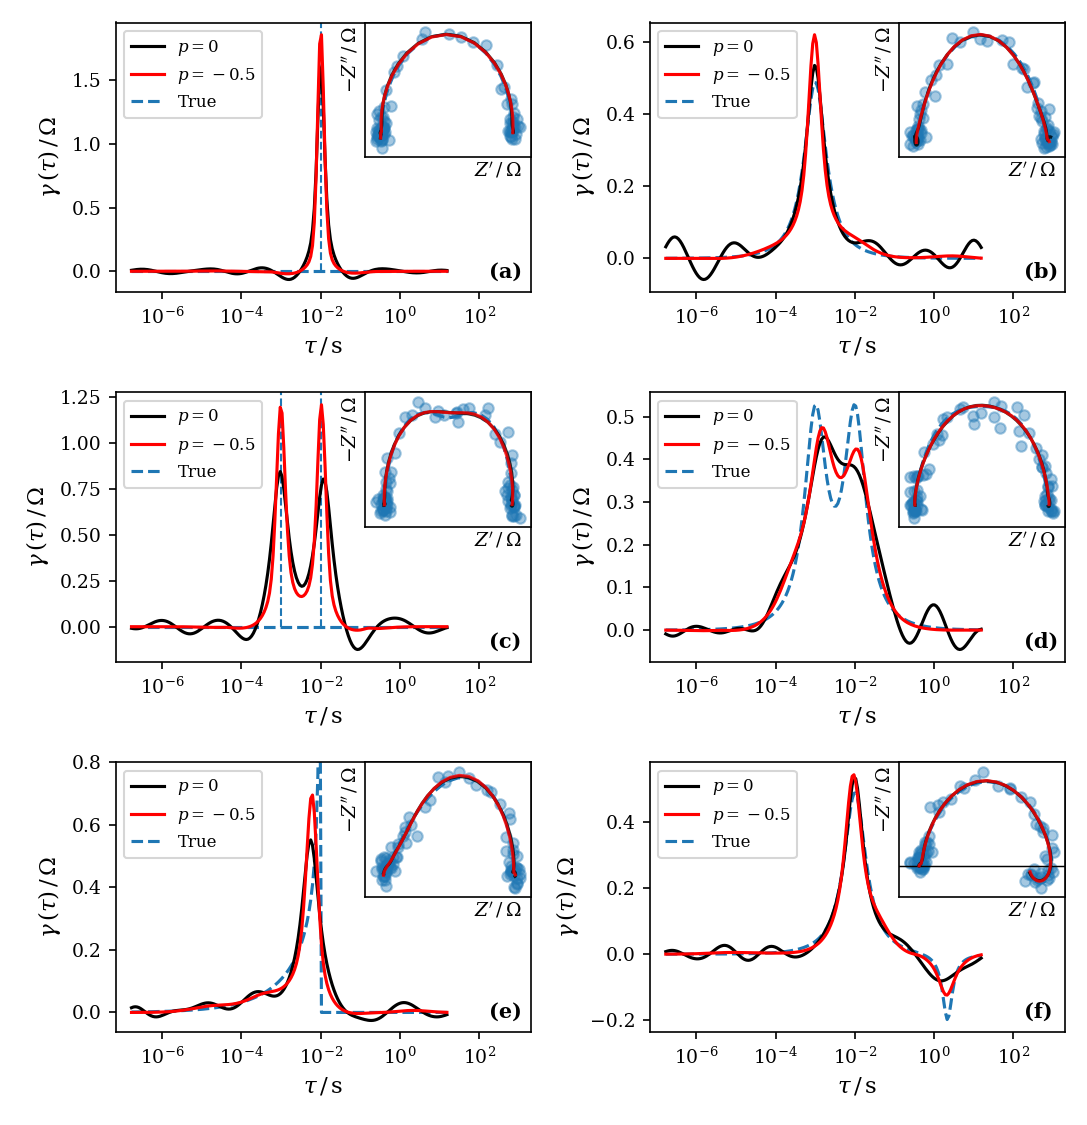

../bayes-drt\drt.py:327: UserWarning: Hyperparametric solution did not converge within 20 iterations
  iter += 1
../bayes-drt\drt.py:327: UserWarning: Hyperparametric solution did not converge within 20 iterations
  iter += 1
../bayes-drt\drt.py:327: UserWarning: Hyperparametric solution did not converge within 20 iterations
  iter += 1
../bayes-drt\drt.py:327: UserWarning: Hyperparametric solution did not converge within 20 iterations
  iter += 1
../bayes-drt\drt.py:327: UserWarning: Hyperparametric solution did not converge within 20 iterations
  iter += 1
../bayes-drt\drt.py:327: UserWarning: Hyperparametric solution did not converge within 20 iterations
  iter += 1


In [373]:
"6 basic simulated spectra"
fig,axes = plt.subplots(3,2,figsize=(7.25,7.5))

circuits = ['RC','ZARC','2RC','2ZARC','Gerischer','ZARC-RL']
err_model = 'uniform'
noise_level = 2.5

for circ,ax in zip(circuits,axes.ravel()):
    Z_file = os.path.join(data_path,'simulated',f'Z_{circ}_noiseless.csv')
    Zn_file = os.path.join(data_path,'simulated',f'Z_{circ}_{err_model}_{noise_level}.csv')
     
    # plot impedance data on inset
    axi = ax.inset_axes([0.6,0.5,0.4,0.5])
    Zdf = pd.read_csv(Z_file)
    Zndf = pd.read_csv(Zn_file)
    gt.plot_nyquist(Zdf,ax=axi,label='True',plot_func='plot',ls='--',label_size=tick_size)
    gt.plot_nyquist(Zndf,ax=axi,label='Data',s=25,alpha=0.4,label_size=tick_size)
    if circ=='ZARC-RL':
        axi.axhline(0,lw=0.7,c='k')
            
    # hyper ridge fit (p=0)
    Zc = Zndf['Zreal'].values + 1j*Zndf['Zimag'].values
    dri.ridge_fit(Zndf['Freq'].values,Zc,beta=2.5,lambda_0=1e-2,reg_ord=2,dZ=False)
    
    # plot estimated DRT
    ax.plot(g_true['tau'],dri.drt(g_true['tau']),label='$p=0$',c='k')

    # plot impedance fit
    Z_pred = dri.predict(dri.f_train)
    Zres = gt.construct_eis_df(dri.f_train,Z_pred)
    gt.plot_nyquist(Zres,ax=axi,plot_func='plot',c='k',label_size=tick_size,alpha=0.8)
    
    # hyper ridge fit (p=-0.5)
    Zc = Zndf['Zreal'].values + 1j*Zndf['Zimag'].values
    dri.ridge_fit(Zndf['Freq'].values,Zc,beta=2.5,lambda_0=1e-2,reg_ord=2,dZ=True)
    
    # plot estimated DRT
    ax.plot(g_true['tau'],dri.drt(g_true['tau']),label='$p=-0.5$',c='r')

    # plot impedance fit
    Z_pred = dri.predict(dri.f_train)
    Zres = gt.construct_eis_df(dri.f_train,Z_pred)
    gt.plot_nyquist(Zres,ax=axi,plot_func='plot',c='r',label_size=tick_size,alpha=0.8)
            
    ax.set_xscale('log')
    ax.set_xlabel(r'$\tau \, / \, $s')
    ax.set_ylabel(r'$\gamma\,(\tau) \, / \, \Omega$')
    ax.set_xlim(ax.get_xlim()[0],2e3)
    
    axi.set_xticks([])
    axi.set_yticks([])
    axi.get_legend().remove()
    axi.xaxis.set_label_coords(0.8,-0.025)
    axi.yaxis.set_label_coords(-0.025,0.72)
    
    if circ=='Gerischer':
        ax.set_ylim(ax.get_ylim()[0],0.8)
        
    # plot true DRT
    tmin = 1/(2*np.pi*Zdf['Freq'].max())
    tmax = 1/(2*np.pi*Zdf['Freq'].min())
    if circ=='RC':
        ax.axvline(1e-2,lw=1,ls='--',ymin=ax.transLimits.transform((1,0))[1],zorder=-10)
        ax.axhline(0,ls='--',zorder=-10,xmin=ax.transLimits.transform((np.log10(tmin),0))[0],
                    xmax=ax.transLimits.transform((np.log10(tmax),0))[0],label='True')
    elif circ=='2RC':
        ax.axvline(1e-2,lw=1,ls='--',ymin=ax.transLimits.transform((1,0))[1],zorder=-10)
        ax.axvline(1e-3,lw=1,ls='--',ymin=ax.transLimits.transform((1,0))[1],zorder=-10)
        ax.axhline(0,ls='--',zorder=-10,xmin=ax.transLimits.transform((np.log10(tmin),0))[0],
                    xmax=ax.transLimits.transform((np.log10(tmax),0))[0],label='True')
    else:
        g_file = os.path.join(data_path,'simulated',f'gamma_{circ}.csv')
        g_true = pd.read_csv(g_file)
        g_true = g_true[(g_true['tau']>= 1/(2*np.pi*Zdf['Freq'].max())) & (g_true['tau']<= 1/(2*np.pi*Zdf['Freq'].min()))]
        ax.plot(g_true['tau'],g_true['gamma'],label='True',ls='--',zorder=-10)
        
    ax.legend(loc='upper left')
        
# subfigure labels
for n,ax in enumerate(axes.ravel()):
    let = chr(n+97)
    ax.text(0.9,0.05,f'({let})',transform=ax.transAxes,fontweight='bold')
    
fig.tight_layout()
fig.savefig(os.path.join(plotdir,'InitDRTs_AllSimData_2.5.jpg'),dpi=500)
fig.savefig(os.path.join(latexdir,'InitDRTs_AllSimData_2.5.pdf'),dpi=500)

# Old

In [468]:
def compare_drt_2x2(circ,err_model,noise_level):
    fig, axes = plt.subplots(2,2,figsize=(7.25,5),sharey=False)
    
    # plot impedance data
    Z_file = os.path.join(data_path,'simulated',f'Z_{circ}_noiseless.csv')
    Zn_file = os.path.join(data_path,'simulated',f'Z_{circ}_{err_model}_{noise_level}.csv')
    Zdf = pd.read_csv(Z_file)
    Zndf = pd.read_csv(Zn_file)
    gt.plot_nyquist(Zdf,ax=axes[0,0],label='True',plot_func='plot',ls='--',label_size=label_size)
    gt.plot_nyquist(Zndf,ax=axes[0,0],label='Data',s=30,alpha=0.4,label_size=label_size)
    
    # plot true DRT
    if circ=='RC':
        for ax in axes.ravel()[1:]:
            ax.axvline(1e-2,lw=1,label='True',ls='--')
    elif circ=='2RC':
        for ax in axes.ravel()[1:]:
            ax.axvline(1e-2,lw=1,label='True',ls='--')
            ax.axvline(1e-3,lw=1,ls='--')
    else:
        g_file = os.path.join(data_path,'simulated',f'gamma_{circ}.csv')
        g_true = pd.read_csv(g_file)
        g_true = g_true[(g_true['tau']>= 1/(2*np.pi*Zdf['Freq'].max())) & (g_true['tau']<= 1/(2*np.pi*Zdf['Freq'].min()))]
        for ax in axes.ravel()[1:]:
            ax.plot(g_true['tau'],g_true['gamma'],label='True',ls='--')

    # share y axes for all DRT plots
    axes[0,1].get_shared_y_axes().join(axes[0,1],axes[1,0],axes[1,1])

    # get results filenames
    fname = os.path.split(Zn_file)[1]
    suffix = fname[1:]
    Zout = f'Zout{suffix}'
    Gout = f'Gout{suffix}'

    # plot DRT and impedance fit for each model
    for i,(model_name,info) in enumerate(model_info.items()):
        path = info['path']
        color = info['color']
        Zres = pd.read_csv(os.path.join(path,Zout))
        Gres = pd.read_csv(os.path.join(path,Gout))
        # limit DRT range to data range to avoid large CIs on GP
        Gres = Gres[(Gres['tau']>= 1/(2*np.pi*Zdf['Freq'].max())) & (Gres['tau']<= 1/(2*np.pi*Zdf['Freq'].min()))]

        # plot DRT on appropriate axis
        if model_name=='PM':
            axes[0,1].plot(Gres['tau'],Gres['gamma'],label='PM',c=color)
            axes[0,1].fill_between(Gres['tau'],Gres['gamma_lo'],Gres['gamma_hi'],alpha=0.2,label='95% CI',
                                   color=color,lw=0)
        elif model_name=='MAP':
            axes[1,0].plot(Gres['tau'],Gres['gamma'],label='MAP',c=color)
        elif model_name=='GP':
            axes[1,1].plot(Gres['tau'],Gres['gamma'],c=color,label='GP Mean')
            axes[1,1].fill_between(Gres['tau'],Gres['gamma']-3*Gres['sigma_gamma'],Gres['gamma']+3*Gres['sigma_gamma'],
                                alpha=0.25,color=color,label='GP 95% CI',lw=0)
        else:
            axes[1,1].plot(Gres['tau'],Gres['gamma'],c=color,label=model_name)

        # plot fitted impedance
        if model_name=='PM':
            # parse complex numbers
            real_cols = ['freq','Zreal','Zimag']
            for col in real_cols:
                Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x))
                Zres[col] = np.real(Zres[col])
            imag_cols = ['Zlo','Zhi']
            for col in imag_cols:
                Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x))
        elif model_name=='GP':
            'GP does not predict Zreal. Use predicted Zimag with true Zreal'
            df = pd.read_csv(Z_file)
            Z_combo = df['Zreal'] + 1j*Zres['Zimag'].values[::-1]
            Zres = gt.construct_eis_df(df['Freq'],Z_combo.values)
    #             gt.plot_nyquist(df,plot_func='plot',ax=axes[0,i])
    #             axes[1,i].plot(Gres['tau'],Gres['gamma'])        
        gt.plot_nyquist(Zres,ax=axes[0,0],plot_func='plot',label=model_name,c=color,lw=2,alpha=0.6,label_size=label_size)

    for ax in axes.ravel()[1:]:
        ax.set_xscale('log')
        ax.legend(fontsize=tick_size-1,loc='upper left')
        ax.set_xlabel(r'$\tau \, / \, $s',size=label_size)
        ax.set_ylabel(r'$\gamma\,(\tau) \, / \, \Omega$',size=label_size)

    for ax in axes.ravel():
        ax.tick_params(labelsize=tick_size)

    # reorder legend entries for Nyquist plot    
    h,l = axes[0,0].get_legend_handles_labels()
    srt_idx = [0,-1,1,2,3,4]
    axes[0,0].legend(handles=[h[idx] for idx in srt_idx],labels=[l[idx] for idx in srt_idx],
                     fontsize=tick_size-1)

    if circ=='Gerischer':
        axes[0,1].set_ylim(axes[0,1].get_ylim()[0],0.8)
        
    # subfigure labels
    for n,ax in enumerate(axes.ravel()):
        let = chr(n+97)
        ax.text(0.9,0.9,f'({let})',transform=ax.transAxes,fontweight='bold')

    fig.tight_layout()
    return fig, axes

<IPython.core.display.Javascript object>


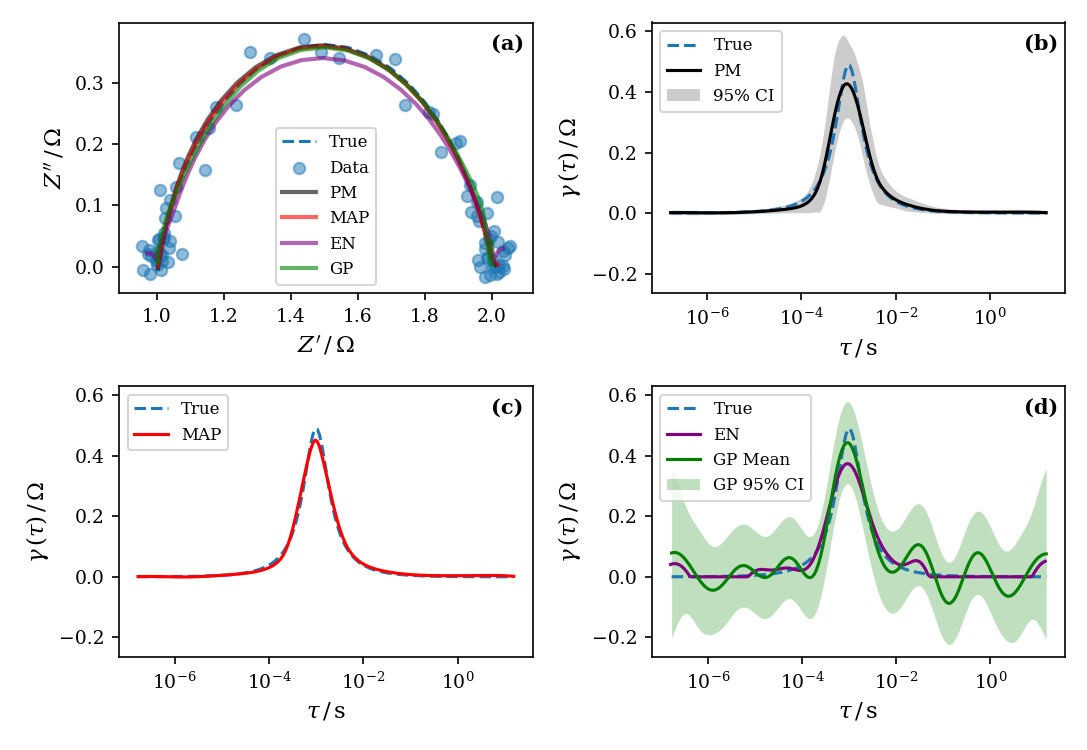

In [425]:
circ = 'ZARC'
err_model = 'uniform'
noise_level = 2.5
fig, axes = compare_drt(circ,err_model,noise_level)
suffix = f'_{circ}_{err_model}_{noise_level}'
fig.savefig(os.path.join(plotdir,f'DrtComparison{suffix}.jpg'),dpi=500)
fig.savefig(os.path.join(latexdir,f'DrtComparison{suffix}.jpg'),dpi=500)

<IPython.core.display.Javascript object>


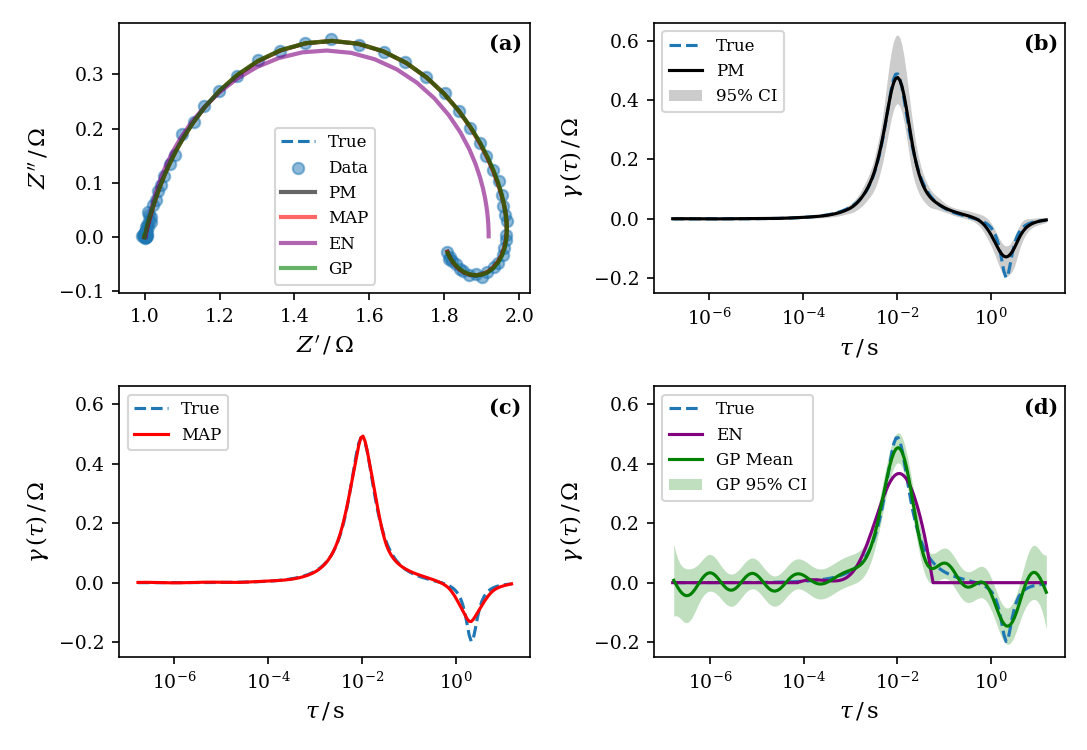

In [426]:
circ = 'ZARC-RL'
err_model = 'uniform'
noise_level = 0.25
fig, axes = compare_drt(circ,err_model,noise_level)
suffix = f'_{circ}_{err_model}_{noise_level}'
fig.savefig(os.path.join(plotdir,f'DrtComparison{suffix}.jpg'),dpi=500)
fig.savefig(os.path.join(latexdir,f'DrtComparison{suffix}.jpg'),dpi=500)

<IPython.core.display.Javascript object>


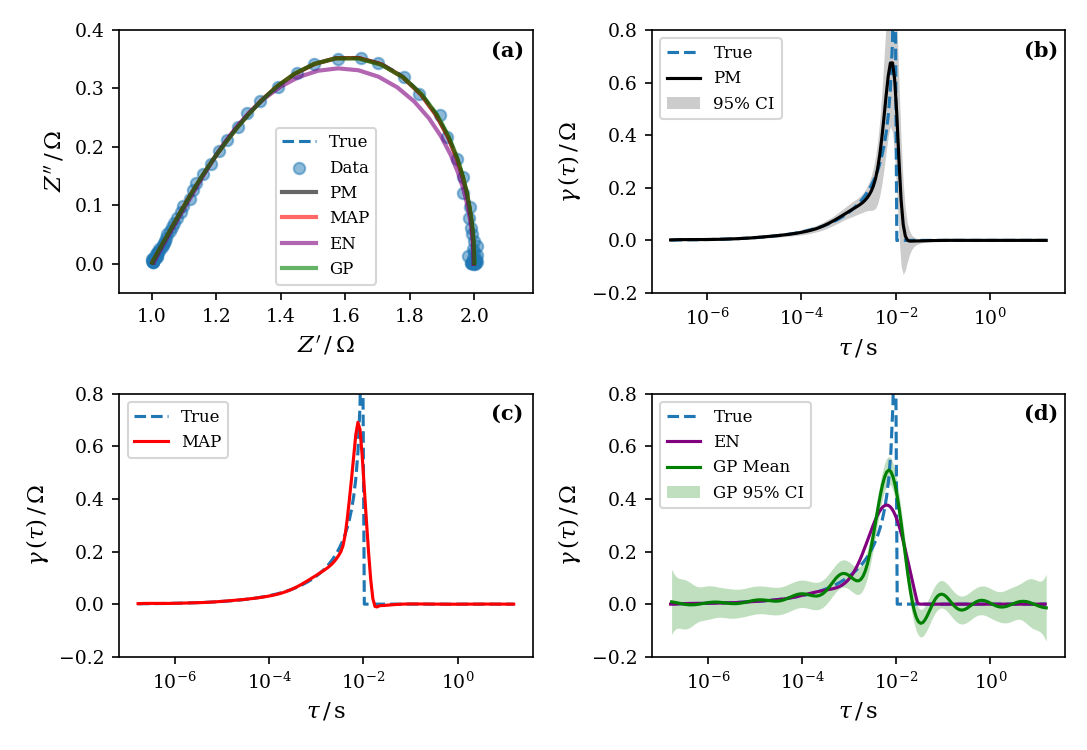

<IPython.core.display.Javascript object>


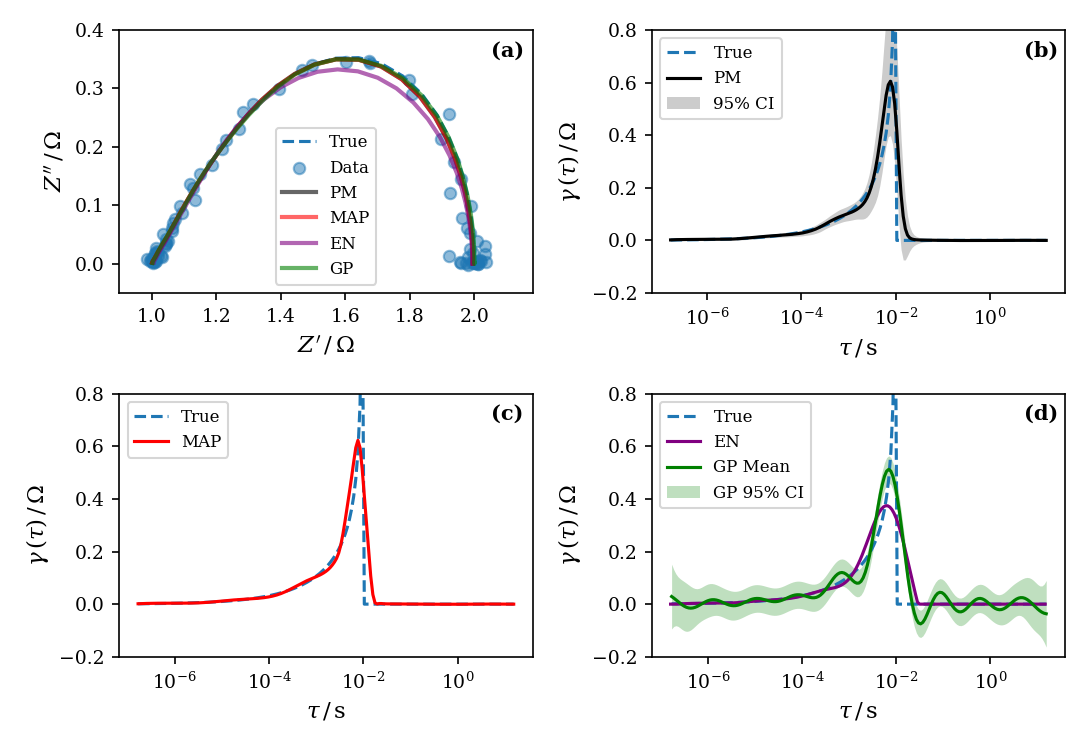

<IPython.core.display.Javascript object>


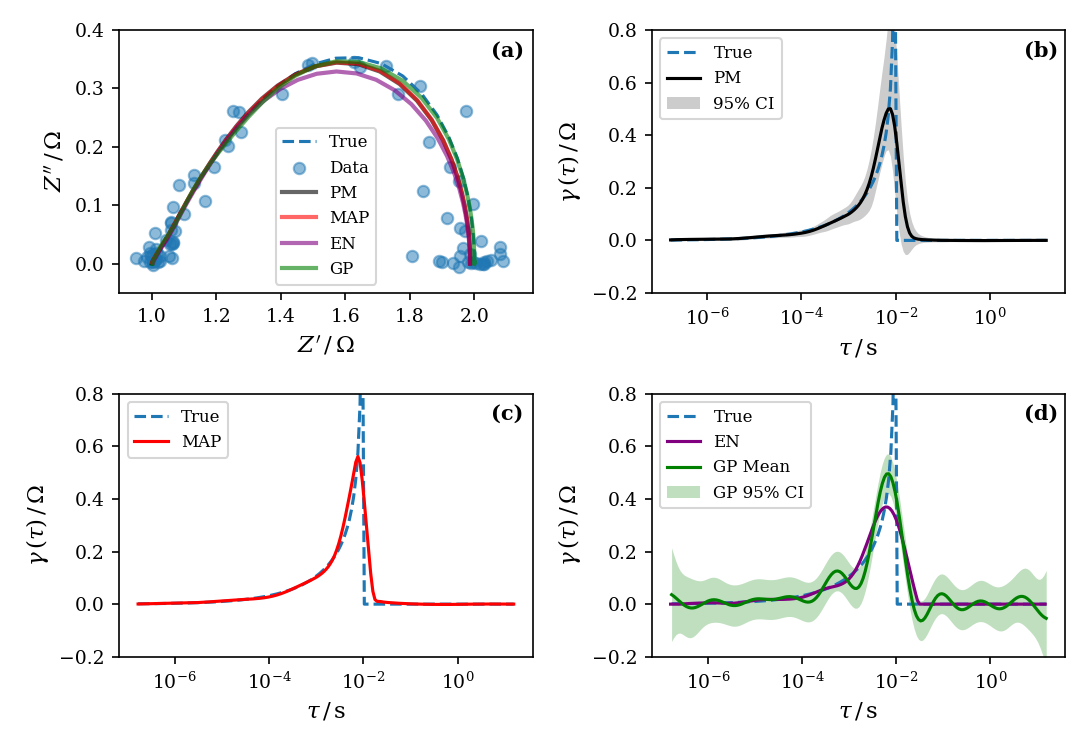

In [427]:
circ = 'Gerischer'
err_model = 'Macdonald'
for noise_level in [0.25,1.0,2.5]:
    fig, axes = compare_drt(circ,err_model,noise_level)
    # set consistent axis limits across figures
    axes[0,0].set_xlim(0.9,2.18)
    axes[0,0].set_ylim(-0.05,0.4)
    for ax in axes.ravel()[1:]:
        ax.set_ylim(-0.2,0.8)
    suffix = f'_{circ}_{err_model}_{noise_level}'
    fig.savefig(os.path.join(plotdir,f'DrtComparison{suffix}.jpg'),dpi=500)
    fig.savefig(os.path.join(latexdir,f'DrtComparison{suffix}.jpg'),dpi=500)

<IPython.core.display.Javascript object>


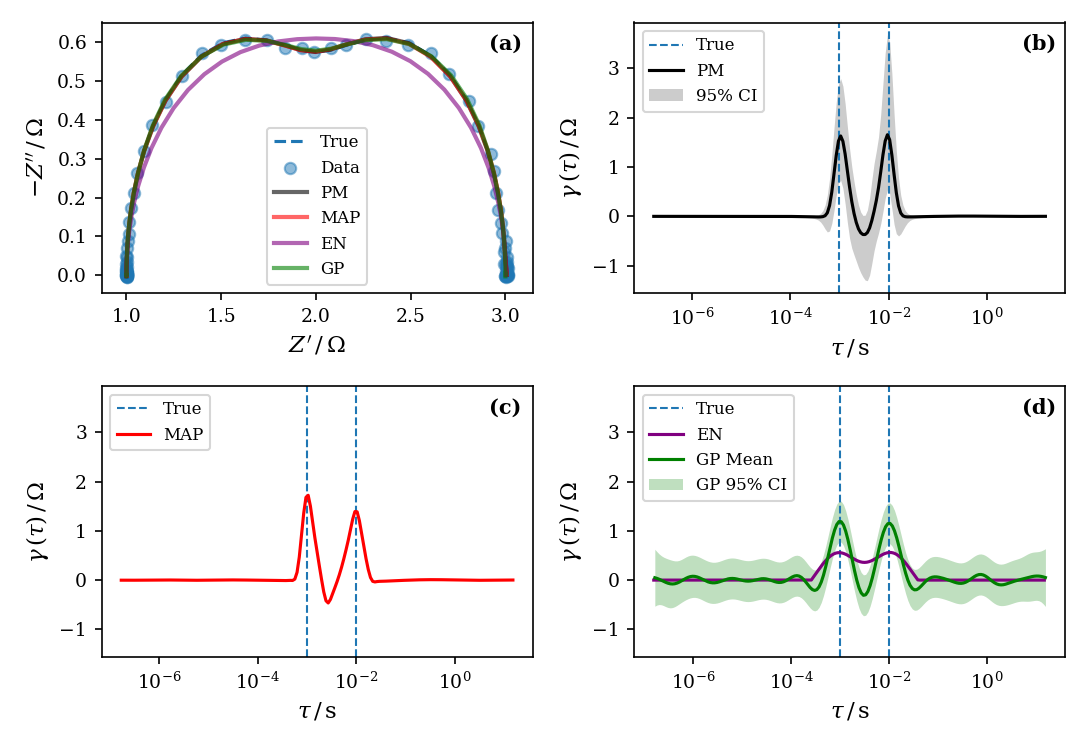

<IPython.core.display.Javascript object>


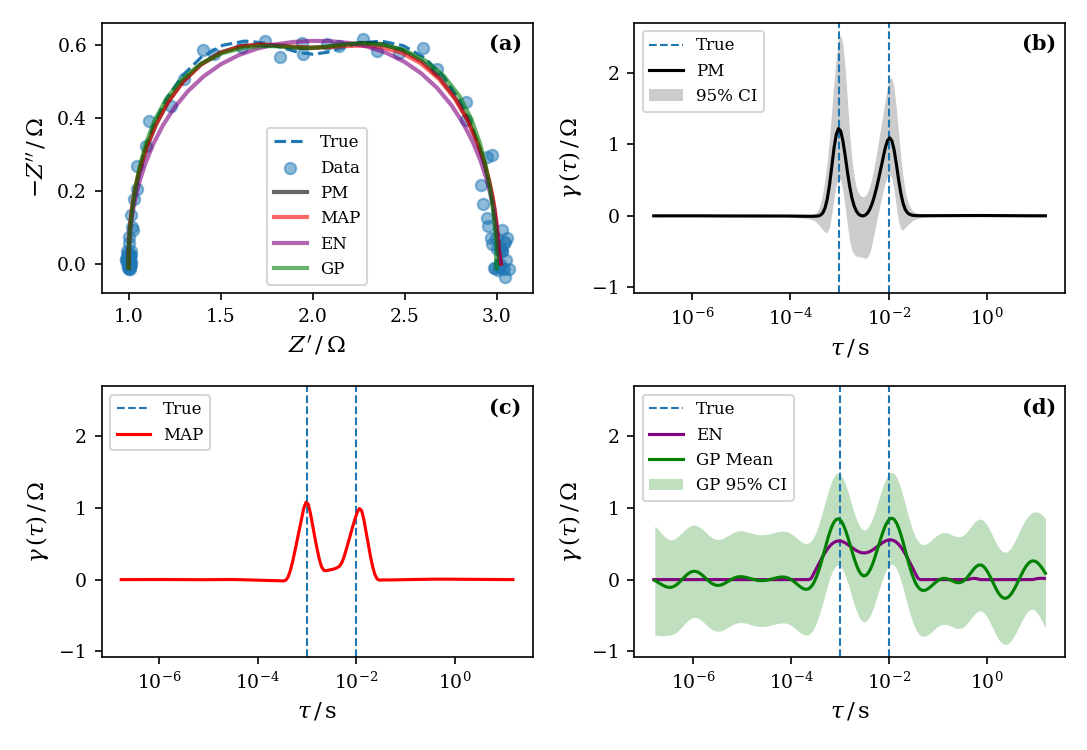

<IPython.core.display.Javascript object>


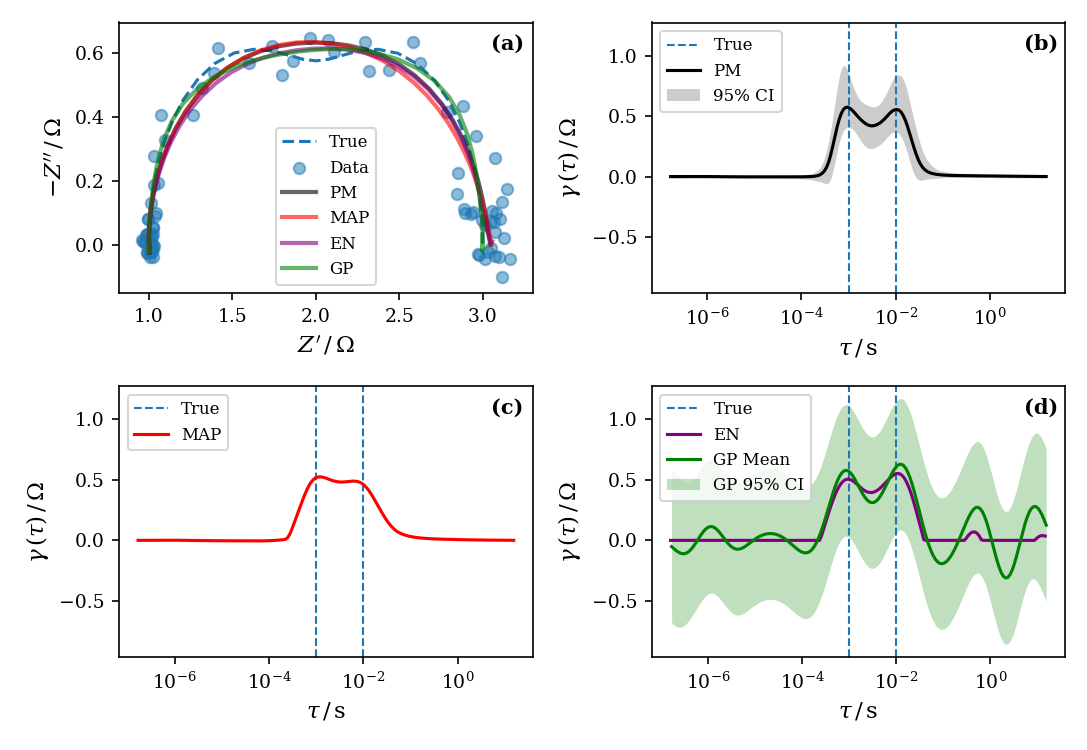

In [502]:
circ = '2RC'
err_model = 'Orazem'
for noise_level in [0.25,1.0,2.5]:
    fig, axes = compare_drt(circ,err_model,noise_level)
    # set consistent axis limits across figures
#     axes[0,0].set_xlim(0.8,3.3)
#     axes[0,0].set_ylim(-0.22,0.7)
#     for ax in axes.ravel()[1:]:
#         ax.set_ylim(-0.3,0.7)
    suffix = f'_{circ}_{err_model}_{noise_level}'
#     fig.savefig(os.path.join(plotdir,f'DrtComparison{suffix}.jpg'),dpi=500)
#     fig.savefig(os.path.join(latexdir,f'DrtComparison{suffix}.jpg'),dpi=500)